# Группировка и анализ пользователей приложения "Ненужные вещи"

## Материалы по проекту: <a class = "tocSkip">
* [Презентация](https://disk.yandex.ru/i/38K3hONC4R_amw)
* [Дашборд](https://public.tableau.com/views/Mobile_App_events_by_type/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link)

## Цель проекта

Для приложения **`Ненужные вещи`** нужно выполнить следующие задачи:

1. **Разделить пользователей на группы** на основе:
    * Retention Rate,
    * время в приложении,
    * частота действий,
    * конверсии в целевое действие


2. На основе исследовательского анализа данных **проверить гипотезы**:
    * Некоторые пользователи установили приложение по ссылке из `yandex` , другие — из `google`. Проверьте гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов
    * Пользователи, которые посмотрели фотографии в объявлении демонстрируют конверсию выше, чем пользователи, которые не смотрели фотографии
    
    
3. По возможности **дать дополнительные рекомендации** на основе анализа данных


4. Построить дашборд в **Tableau** по критериям:
    * Построить диаграмму распределения количества событий по типу события
    * Добавить индикатор количества пользователей
    * Добавить фильтр дашборда по дате совершения события

## Описание данных

Датасет содержит данные о событиях, совершенных в мобильном приложении `"Ненужные вещи"`. В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после `7 октября 2019 года`.

Датасет `mobile_dataset.csv` содержит колонки:
* `event.time` — время совершения
* `event.name` — название события
* `user.id` — идентификатор пользователя

Датасет `mobile_sources.csv` содержит колонки:
* `userId` — идентификатор пользователя
* `source` — источник, с которого пользователь установил приложение

Расшифровки событий:
* `advert_open` — открытие карточки объявления
* `photos_show` — просмотр фотографий в объявлении
* `tips_show` — пользователь увидел рекомендованные объявления
* `tips_click` — пользователь кликнул по рекомендованному объявлению
* `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
* `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
* `map` — пользователь открыл карту размещенных объявлений
* `search_1` — `search_7` — разные события, связанные с поиском по сайту
* `favorites_add` — добавление объявления в избранное

## План

1. Прочитать файлы
2. Сделать предобработку данных
3. Провести исследовательский анализ 
4. Разделить пользователей на группы и проверить продление и конверсию в них
5. Проверить 2 гипотезы
6. Дать общий вывод исследования
    * Подготовить презентацию
    * Составить дешборд
    * Написать выводы текстом

## Предобработка данных

### Загружаем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import datetime as dt
import seaborn as sns

from scipy import stats as st
import math as mth

import plotly.express as px
from plotly import graph_objects as go

from statsmodels.stats.weightstats import ztest as ztest

### Читаем файл

In [2]:
mobile_sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_sources.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

In [3]:
display(mobile_sources.head())
mobile_sources.info()

userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [4]:
mobile_sources['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

In [5]:
display(mobile_dataset.head())
mobile_dataset.info()

event.time   event.name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320    tips_show   
2  2019-10-07 00:00:02.245341    tips_show   
3  2019-10-07 00:00:07.039334    tips_show   
4  2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


### Формат и названия колонок

#### Название колонок

* Поменяем в `mobile_sources`

In [6]:
mobile_sources = mobile_sources.rename(columns={'userId': 'user_id'})

In [7]:
mobile_sources.head(1)

user_id source
0  020292ab-89bc-4156-9acf-68bc2783f894  other

* Теперь в `mobile_dataset`

In [8]:
mobile_dataset = mobile_dataset.rename(columns={'event.time': 'event_time', 
                                                'event.name': 'event_name', 
                                                'user.id': 'user_id'})

In [9]:
mobile_dataset.head(1)

event_time   event_name  \
0  2019-10-07 00:00:00.431357  advert_open   

                                user_id  
0  020292ab-89bc-4156-9acf-68bc2783f894

#### Формат колонок

Приведем колонку `event_time` датафрейма `mobile_dataset` в формат даты

In [10]:
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'])

In [11]:
mobile_dataset.head(1)

event_time   event_name  \
0 2019-10-07 00:00:00.431357  advert_open   

                                user_id  
0  020292ab-89bc-4156-9acf-68bc2783f894

In [12]:
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


### Дубликаты и пропуски

#### Дубликаты 

* `mobile_datasets`

Проверим сначала на неявные дубликаты (что нет ошибок в `event_name`), а затем сделаем полную проверку на полные дубликаты

In [13]:
sorted(mobile_dataset['event_name'].unique())

['advert_open',
 'contacts_call',
 'contacts_show',
 'favorites_add',
 'map',
 'photos_show',
 'search_1',
 'search_2',
 'search_3',
 'search_4',
 'search_5',
 'search_6',
 'search_7',
 'show_contacts',
 'tips_click',
 'tips_show']

Видим, что есть два названия событий, которые значат одно и тоже: `contacts_show` и `show_contacts`

Поскольку значат они одно и тоже, то заменим все событий на `contacts_show`

In [14]:
# через replace заменим значения в колонке и перезапишем ее
mobile_dataset['event_name'] = mobile_dataset['event_name'].replace('show_contacts', 'contacts_show')

In [15]:
# проверяем
sorted(mobile_dataset['event_name'].unique())

['advert_open',
 'contacts_call',
 'contacts_show',
 'favorites_add',
 'map',
 'photos_show',
 'search_1',
 'search_2',
 'search_3',
 'search_4',
 'search_5',
 'search_6',
 'search_7',
 'tips_click',
 'tips_show']

Успешно заменили. Теперь сделаем проверку на полные дубликаты

In [16]:
mobile_dataset.duplicated().sum()

0

* `mobile_sources`

Теперь сделаем проверку на полные дубликаты в источниках

In [17]:
mobile_sources.duplicated().sum()

0

#### Ошибки

Проверим, что каждому юзеру соответствует один источник, из которого он устанавливает приложение

In [18]:
# группируем по пользователям, считаем источники на пользователя и оставляем уникальные кол-ва источников
mobile_sources.groupby('user_id').agg({'source': 'count'})['source'].unique()

array([1], dtype=int64)

Таких ошибок нет

#### Пропуски

* Посчитаем пропуски по каждому датасету

In [19]:
mobile_sources.isna().sum()

user_id    0
source     0
dtype: int64

In [20]:
mobile_dataset.isna().sum()

event_time    0
event_name    0
user_id       0
dtype: int64

Пропусков нет ни в одном датасете

* Проверим, все ли пользователи одинаковые в двух датасетах

Сделаем перекрестную проверку уникальных пользователей одного датасета в другом

In [21]:
mobile_sources['user_id'] in mobile_dataset['user_id'].agg('unique')

True

In [22]:
mobile_dataset['user_id'].unique() in mobile_sources['user_id'].unique()

True

Дополнительно сделаем проверку через два отдельных датасета с уникальными пользователями и посчитаем, количество совпадений

In [23]:
(
    mobile_sources.groupby('user_id').agg('count').reset_index().drop(labels='source', axis=1) == \
    mobile_dataset.groupby('user_id').agg('count').reset_index().drop(labels=['event_time', 
                                                                              'event_name'], axis=1)
)['user_id'].sum()

4293

Получилось 4293 совпадения. Проверим кол-во уникальных пользователей в каждом датасете

In [24]:
display(mobile_sources.groupby('user_id').agg('count').reset_index().drop(labels='source', axis=1).count())

mobile_dataset.groupby('user_id').agg('count').reset_index().drop(labels=['event_time', 'event_name'], axis=1).count()

user_id    4293
dtype: int64

user_id    4293
dtype: int64

Количество пользователей в каждом датасете и количество совпадений одинаковое. Ошибок нет

### Выделение сессии пользователя

Новые сессии будем выделять с `30-минутным интервалом` между действиями, поскольку если пользователь не был столько времени в приложении, то последующий заход в рамках будет уже скорее новой сессиией

In [25]:
# остортируем данные по пользователям и времени собития
mobile_dataset = mobile_dataset.sort_values(['user_id', 'event_time'])

In [26]:
# выделим дельты между действиями в отдельную переменную
diff_timestamp = mobile_dataset.groupby('user_id')['event_time'].diff()

# в переменной new_session отметим, где должна начинаться новая сессия после 30 мин перерыва
new_session = (diff_timestamp.isnull()) | (diff_timestamp > pd.Timedelta('30Min'))

# Проставим идентификатор сессии `session_id` для каждого пользователя
mobile_dataset['session_id'] = mobile_dataset.loc[new_session, ['user_id', 'event_time']] \
    .groupby('user_id').rank(method='first').astype(int)

# Заполним все NaN в идентификаторах значением текущей сессии (NaN появляется, потому что не проставляется новая сессия)
mobile_dataset['session_id'] = mobile_dataset['session_id'].fillna(method='ffill').astype(int)

In [27]:
# проверяем
mobile_dataset.head(20)

event_time event_name  \
805   2019-10-07 13:39:45.989359  tips_show   
806   2019-10-07 13:40:31.052909  tips_show   
809   2019-10-07 13:41:05.722489  tips_show   
820   2019-10-07 13:43:20.735461  tips_show   
830   2019-10-07 13:45:30.917502  tips_show   
831   2019-10-07 13:45:43.212340  tips_show   
832   2019-10-07 13:46:31.033718  tips_show   
836   2019-10-07 13:47:32.860234  tips_show   
839   2019-10-07 13:49:41.716617  tips_show   
6541  2019-10-09 18:33:55.577963        map   
6546  2019-10-09 18:35:28.260975        map   
6565  2019-10-09 18:40:28.738785  tips_show   
6566  2019-10-09 18:42:22.963948  tips_show   
36412 2019-10-21 19:52:30.778932  tips_show   
36416 2019-10-21 19:53:17.165009  tips_show   
36419 2019-10-21 19:53:38.767230        map   
36421 2019-10-21 19:54:45.009859  tips_show   
36423 2019-10-21 19:54:56.854811  tips_show   
36430 2019-10-21 19:56:49.417415        map   
36435 2019-10-21 19:57:21.124551  tips_show   

                                    user_id  session_id  
805    0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1  
806    0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1  
809    0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1  
820    0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1  
830    0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1  
831    0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1  
832    0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1  
836    0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1  
839    0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1  
6541   0001b1d5-b74a-4cbf-aeb0-7df5947bf349           2  
6546   0001b1d5-b74a-4cbf-aeb0-7df5947bf349           2  
6565   0001b1d5-b74a-4cbf-aeb0-7df5947bf349           2  
6566   0001b1d5-b74a-4cbf-aeb0-7df5947bf349           2  
36412  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           3  
36416  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           3  
36419  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           3  
36421  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           3  
36423  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           3  
36430  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           3  
36435  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           3

Идентификаторы сессий проставились корректно

### Объединение файлов в единую базу

Соединим два файла с сессиями и источниками в одну базу в переменной `mobile_df`

In [28]:
# сливаем методом merge по user_id методом inner (user_id полностью совпадают)
mobile_df = mobile_dataset.merge(mobile_sources, on='user_id', how='inner')

In [29]:
# проверям
mobile_df.head()

event_time event_name                               user_id  \
0 2019-10-07 13:39:45.989359  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
1 2019-10-07 13:40:31.052909  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
2 2019-10-07 13:41:05.722489  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
3 2019-10-07 13:43:20.735461  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
4 2019-10-07 13:45:30.917502  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   

   session_id source  
0           1  other  
1           1  other  
2           1  other  
3           1  other  
4           1  other

In [30]:
# доп проверка на пропуски
mobile_df.isna().sum()

event_time    0
event_name    0
user_id       0
session_id    0
source        0
dtype: int64

Упорядочим колонки в удобном порядке:
1. user_id
2. source
3. event_name
4. event_time
5. session_id

In [31]:
mobile_df = mobile_df[['user_id', 'source', 'event_name', 'event_time', 'session_id']]

In [32]:
mobile_df.head(1)

user_id source event_name  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   

                  event_time  session_id  
0 2019-10-07 13:39:45.989359           1

### Вывод

* На вход получили два файла без ошибок, пропусков и дубликатов (похвалить команду сбора данных)
* В файле действиями пользователей сделали разбивку по сессиям по 30-мин интервалу между действиями
* Объединили два сета данных (сессии и источники) в один и упорядочили колонки

## Исследовательский анализ данных

### Общий анализ данных

#### Период исследования

Проверим, за какой период у нас данные

In [33]:
print('Временной интервал данных:')
display(mobile_df['event_time'].agg(['min', 'max']))

print('')
print('Время проведения исследования:')
mobile_df['event_time'].agg(['min', 'max']).diff()[1]

Временной интервал данных:


min   2019-10-07 00:00:00.431357
max   2019-11-03 23:58:12.532487
Name: event_time, dtype: datetime64[ns]


Время проведения исследования:


Timedelta('27 days 23:58:12.101130')

* с 7 октября 2019 до 3 ноября 2019 = 28 дней
* с тех. заданием информация совпадает

In [34]:
# запишем на будущее переменную с общим количеством дней
total_days = mobile_df['event_time'].agg(['min', 'max']).diff()[1].days

total_days

27

#### Сессии по пользователям 

In [35]:
# посмотрим распределение по квартилям и среднюю
mobile_df.groupby('user_id')['session_id'].nunique().describe()

count    4293.000000
mean        2.415094
std         3.536466
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        99.000000
Name: session_id, dtype: float64

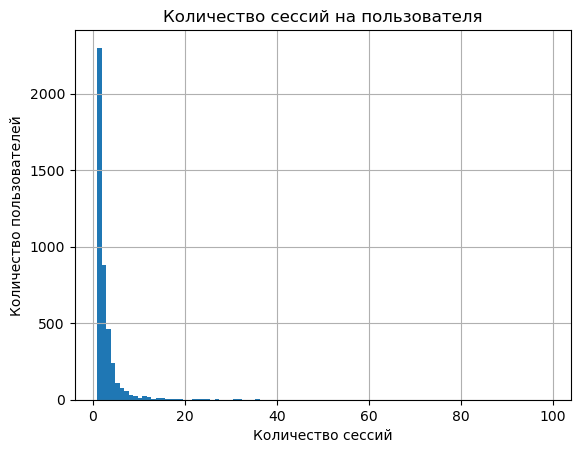

In [36]:
# проверим, как выглядит распределение на графике
mobile_df.groupby('user_id')['session_id'].nunique().hist(bins=100);

plt.xlabel('Количество сессий');
plt.ylabel('Количество пользователей');
plt.title('Количество сессий на пользователя');

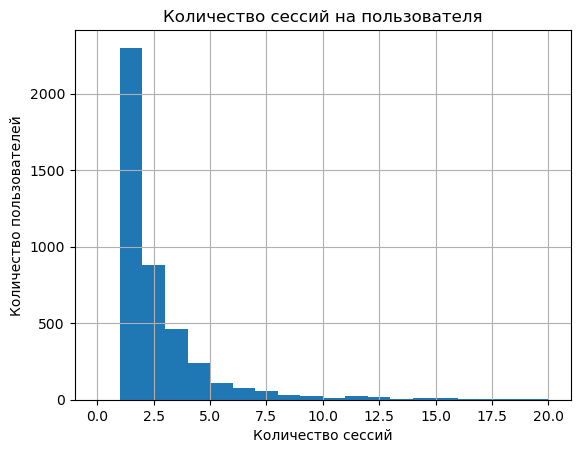

In [37]:
# посмотрим сессии в диапазоне<div class="alert alert-info"> <b>Комментарии студента:</b> Поправил!</div> от 0 до 20
mobile_df.groupby('user_id')['session_id'].nunique().hist(bins=20, range=[0, 20]);

plt.xlabel('Количество сессий');
plt.ylabel('Количество пользователей');
plt.title('Количество сессий на пользователя');

* Среднее количество сессий на пользователя 2.4 при медиане в 1, что говорит о выбросах по пользователям с большим количеством сессий (макс. = 99)
* Самое большое количество пользователей с 1 и 2 сессиями
* 75% пользователей сделали до 3 сессий

#### Сессии по дням и неделям

Добавим сначала колонку с датами по дням

In [38]:
# уберем ошибку SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [39]:
# выделим дни в отдельную колонку
mobile_df['date'] = mobile_df['event_time'].dt.date

In [40]:
mobile_df.head()

user_id source event_name  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
4  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   

                  event_time  session_id        date  
0 2019-10-07 13:39:45.989359           1  2019-10-07  
1 2019-10-07 13:40:31.052909           1  2019-10-07  
2 2019-10-07 13:41:05.722489           1  2019-10-07  
3 2019-10-07 13:43:20.735461           1  2019-10-07  
4 2019-10-07 13:45:30.917502           1  2019-10-07

Дополним таблицу днем недели и номером недели

In [41]:
# выделим день недели в отдельную колонку
mobile_df['weekday'] = mobile_df['event_time'].dt.dayofweek

In [42]:
# Проверим первый и последний день исследования

print(
mobile_df['event_time'].min().weekday(),
mobile_df['event_time'].max().weekday()
    )

0 6


0 и 6 = понедельник и воскресенье. То есть может поделить исследования на 4 календарных недели

In [43]:
# напишем функцию по присвоению недели
def week_num_set(cur_date):
    if cur_date >= dt.date(2019, 10, 7) and cur_date <= dt.date(2019, 10, 13):
        return 'week 1'
    elif cur_date >= dt.date(2019, 10, 14) and cur_date <= dt.date(2019, 10, 20):
        return 'week 2'
    elif cur_date >= dt.date(2019, 10, 21) and cur_date <= dt.date(2019, 10, 27):
        return 'week 3'
    elif cur_date >= dt.date(2019, 10, 28) and cur_date <= dt.date(2019, 11, 3):
        return 'week 4'
    else:
        return 'error! check again'

In [44]:
# применим функцию к колонке с датами
mobile_df['week'] = mobile_df['date'].apply(week_num_set)

In [45]:
mobile_df.head()

user_id source event_name  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
4  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   

                  event_time  session_id        date  weekday    week  
0 2019-10-07 13:39:45.989359           1  2019-10-07        0  week 1  
1 2019-10-07 13:40:31.052909           1  2019-10-07        0  week 1  
2 2019-10-07 13:41:05.722489           1  2019-10-07        0  week 1  
3 2019-10-07 13:43:20.735461           1  2019-10-07        0  week 1  
4 2019-10-07 13:45:30.917502           1  2019-10-07        0  week 1

Строим графики по **временным срезам** (день / неделя / день недели)

In [46]:
# для уникальных сессий группируем по дню неделю и пользователю, считает уникальные сессии по каждому
# вторым шагом группируем по дате / дню недели / неделе, суммируем уникальные сессии пользователей и строим график

for time in ['date', 'week', 'weekday']:

    fig = px.bar(mobile_df.groupby([time, 'user_id'])
                          .agg({'session_id': 'nunique'})
                          .reset_index()
                          .groupby(time)['session_id']
                          .sum())

    fig.update_layout(title='Количество сессий пользователей',
                       xaxis_title=time,
                       yaxis_title='Сессии',
                       showlegend=False)

    fig.show()

* С понедельника по четверг самая высокая активность пользователей: 1535-1583 сессий
* В субботу самая низкая: 1279 сессий

Посмотрим, как поменялось количество сессий **в разрезе недель**

Сделаем сводную таблицу в разрезе пользователей по сессиям, неделям и дням недели

In [47]:
# сделаем новую переменную week_session, предварительно сгруппировав пользователей и посчитав уникальные сессии
week_sessions = pd.pivot_table(mobile_df.groupby(['user_id', 
                                                  'week', 
                                                  'weekday']).agg({'session_id': 'nunique'}).reset_index(),\
                               index='weekday', 
                               columns='week', 
                               values='session_id', 
                               aggfunc='sum')

In [48]:
week_sessions

week     week 1  week 2  week 3  week 4
weekday                                
0           247     389     434     465
1           281     394     414     449
2           281     378     470     454
3           308     413     427     435
4           271     411     413     375
5           230     347     384     318
6           288     354     409     383

Проверим, что уникальные сессии в `week_session` и в распределении по дням недели выше совпадают

In [49]:
week_sessions.sum().sum()

10422

In [50]:
(mobile_df.groupby(['weekday', 'user_id'])
 .agg({'session_id': 'nunique'})
 .reset_index()
 .groupby('weekday')['session_id'].sum().sum()
)

10422

Совпадают. Построим понедельный график по дням

In [51]:
# построим понедельный график по дням
fig = px.line(week_sessions)

fig.update_layout(title='Количество сессий по неделям и дням',
                 xaxis_title='День недели (0 = Понедельник)',
                 yaxis_title='Количество сессий')

fig.show()

* Первая неделя самая слабая по пользователям
* 3-4 недели самые активные
* В целом тренд достаточно схожий с общим: пн-чт самые активные, суббота самая неактивная

#### Пользователи по источникам привлечения

In [52]:
# сделаем в plotly круговую диаграмму по уникальным пользователям и источникам привлечения
fig = go.Figure(data=[go.Pie(
    labels=mobile_df.groupby('source')['user_id'].agg('nunique').index,
    values=mobile_df.groupby('source')['user_id'].agg('nunique')
)])


fig.update_layout(title='Кол-во пользователей по источнику привлечения',
                 width=500)

fig.show()

* Яндекс - самый популярный источник, с которого пользователь поставил приложение: доля 45%
* Гугл 26%, остальные каналы почти 29%

### Retention rate

Напишем функции по расчету RR и построим графики

#### Таблица удержания

In [53]:
mobile_df.head()

user_id source event_name  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
4  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   

                  event_time  session_id        date  weekday    week  
0 2019-10-07 13:39:45.989359           1  2019-10-07        0  week 1  
1 2019-10-07 13:40:31.052909           1  2019-10-07        0  week 1  
2 2019-10-07 13:41:05.722489           1  2019-10-07        0  week 1  
3 2019-10-07 13:43:20.735461           1  2019-10-07        0  week 1  
4 2019-10-07 13:45:30.917502           1  2019-10-07        0  week 1

Посчитаем начало события

In [54]:
first_ts = mobile_df.groupby('user_id').agg({'event_time': 'first'})

In [55]:
first_ts.columns = ['first_ts']

In [56]:
first_ts.head()

first_ts
user_id                                                        
0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-07 13:39:45.989359
00157779-810c-4498-9e05-a1e9e3cedf93 2019-10-19 21:34:33.849769
00463033-5717-4bf1-91b4-09183923b9df 2019-11-01 13:54:35.385028
004690c3-5a84-4bb7-a8af-e0c8f8fca64e 2019-10-18 22:14:05.555052
00551e79-152e-4441-9cf7-565d7eb04090 2019-10-25 16:44:41.263364

Объединим общую таблицу с датой начала первой сессии каждого пользователя

In [57]:
mobile_df = mobile_df.merge(first_ts, on='user_id', how='left')

In [58]:
mobile_df.head()

user_id source event_name  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
4  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   

                  event_time  session_id        date  weekday    week  \
0 2019-10-07 13:39:45.989359           1  2019-10-07        0  week 1   
1 2019-10-07 13:40:31.052909           1  2019-10-07        0  week 1   
2 2019-10-07 13:41:05.722489           1  2019-10-07        0  week 1   
3 2019-10-07 13:43:20.735461           1  2019-10-07        0  week 1   
4 2019-10-07 13:45:30.917502           1  2019-10-07        0  week 1   

                    first_ts  
0 2019-10-07 13:39:45.989359  
1 2019-10-07 13:39:45.989359  
2 2019-10-07 13:39:45.989359  
3 2019-10-07 13:39:45.989359  
4 2019-10-07 13:39:45.989359

Сделаем расчёт лайфтайма

In [59]:
mobile_df['lifetime'] = (mobile_df['event_time'] - mobile_df['first_ts']).dt.days

In [60]:
mobile_df.head()

user_id source event_name  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
4  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   

                  event_time  session_id        date  weekday    week  \
0 2019-10-07 13:39:45.989359           1  2019-10-07        0  week 1   
1 2019-10-07 13:40:31.052909           1  2019-10-07        0  week 1   
2 2019-10-07 13:41:05.722489           1  2019-10-07        0  week 1   
3 2019-10-07 13:43:20.735461           1  2019-10-07        0  week 1   
4 2019-10-07 13:45:30.917502           1  2019-10-07        0  week 1   

                    first_ts  lifetime  
0 2019-10-07 13:39:45.989359         0  
1 2019-10-07 13:39:45.989359         0  
2 2019-10-07 13:39:45.989359         0  
3 2019-10-07 13:39:45.989359         0  
4 2019-10-07 13:39:45.989359         0

Понадобится колонкой с датой первого посещения `first_date`, чтобы построить таблицу удержания с лайфтаймом

In [61]:
mobile_df['first_date'] = mobile_df['first_ts'].dt.date

Строим таблицу удержания и посмотрим на когорты пользователей по дням

In [62]:
mobile_grouped = pd.pivot_table(mobile_df, 
                               index=['first_date'],
                               columns='lifetime',
                               values='user_id',
                               aggfunc='nunique')

mobile_grouped

lifetime       0     1     2     3     4     5     6     7     8     9   ...  \
first_date                                                               ...   
2019-10-07  204.0  25.0  20.0  22.0  11.0   8.0  12.0  16.0  11.0  10.0  ...   
2019-10-08  167.0  27.0  21.0   9.0   7.0  11.0   9.0  12.0  10.0   7.0  ...   
2019-10-09  176.0  13.0  11.0  10.0  12.0  12.0  10.0  13.0  11.0   6.0  ...   
2019-10-10  174.0  16.0  18.0  14.0  17.0  14.0  12.0   9.0  14.0   6.0  ...   
2019-10-11  136.0  12.0  16.0  13.0  12.0  10.0  10.0   6.0   2.0   6.0  ...   
2019-10-12  125.0  16.0  20.0   7.0   8.0  11.0  10.0  11.0  10.0   8.0  ...   
2019-10-13  148.0  19.0  10.0   8.0  10.0   8.0   8.0   7.0   7.0   7.0  ...   
2019-10-14  185.0  21.0  19.0  19.0  15.0  13.0  10.0   8.0  14.0   7.0  ...   
2019-10-15  186.0  26.0  17.0  15.0  10.0  10.0  15.0  14.0  12.0   4.0  ...   
2019-10-16  166.0  21.0  12.0   5.0   8.0  10.0   7.0   9.0  10.0   7.0  ...   
2019-10-17  170.0  24.0  22.0  15.0  15.0  16.0  16.0   8.0   8.0   7.0  ...   
2019-10-18  156.0  13.0  15.0  15.0   9.0  10.0  10.0  12.0  11.0   5.0  ...   
2019-10-19  159.0  15.0  18.0  11.0   4.0   9.0  10.0  10.0   5.0   7.0  ...   
2019-10-20  144.0  15.0  11.0   7.0  10.0   9.0   6.0  10.0   8.0   4.0  ...   
2019-10-21  161.0  15.0  14.0  17.0   7.0   6.0   8.0  15.0   6.0   4.0  ...   
2019-10-22  157.0  18.0  13.0   8.0   6.0   9.0   9.0  11.0   9.0   8.0  ...   
2019-10-23  189.0  18.0  15.0  14.0  10.0  10.0   9.0  11.0   5.0   5.0  ...   
2019-10-24  162.0  17.0  12.0   8.0  10.0  10.0  11.0   5.0   7.0   8.0  ...   
2019-10-25  147.0  13.0  14.0  15.0  14.0   9.0  10.0  10.0   7.0   3.0  ...   
2019-10-26  139.0  21.0   9.0  10.0  12.0   8.0  10.0   4.0   5.0   NaN  ...   
2019-10-27  139.0  10.0  10.0  10.0  11.0  12.0   9.0   6.0   NaN   NaN  ...   
2019-10-28  158.0  15.0  15.0   9.0   9.0   2.0   4.0   NaN   NaN   NaN  ...   
2019-10-29  135.0  23.0  17.0  13.0   8.0   3.0   NaN   NaN   NaN   NaN  ...   
2019-10-30  134.0  19.0  10.0   8.0   3.0   NaN   NaN   NaN   NaN   NaN  ...   
2019-10-31  132.0  12.0   6.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2019-11-01  112.0  11.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2019-11-02   97.0  10.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2019-11-03  135.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

lifetime      17   18   19   20   21   22   23   24   25   26  
first_date                                                     
2019-10-07   4.0  9.0  5.0  3.0  4.0  7.0  7.0  8.0  9.0  6.0  
2019-10-08   5.0  3.0  8.0  6.0  3.0  4.0  7.0  5.0  4.0  2.0  
2019-10-09   3.0  2.0  5.0  2.0  6.0  2.0  1.0  4.0  3.0  NaN  
2019-10-10  11.0  6.0  5.0  3.0  7.0  3.0  2.0  2.0  NaN  NaN  
2019-10-11   8.0  4.0  3.0  3.0  4.0  4.0  2.0  NaN  NaN  NaN  
2019-10-12   5.0  5.0  3.0  3.0  8.0  4.0  NaN  NaN  NaN  NaN  
2019-10-13   2.0  3.0  2.0  5.0  1.0  NaN  NaN  NaN  NaN  NaN  
2019-10-14   7.0  4.0  3.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN  
2019-10-15   6.0  5.0  3.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2019-10-16   2.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2019-10-17   1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2019-10-18   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2019-10-19   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2019-10-20   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2019-10-21   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2019-10-22   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2019-10-23   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2019-10-24   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2019-10-25   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2019-10-26   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2019-10-27   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2019-10-28   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2019-10-29   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

Теперь добавим размер каждой когорты

In [63]:
# вычисляем размеры когорт

cohort_sizes = (
    mobile_df
    .groupby(['first_date'])
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

cohort_sizes.head()

cohort_size
first_date             
2019-10-07          204
2019-10-08          167
2019-10-09          176
2019-10-10          174
2019-10-11          136

Добавляем когорты в `mobile_grouped`

In [64]:
# присоединяет лайфтаймы к когортам, чтобы когорты оказались слева, а не справа. Заполняем нулями пропуски
mobile_grouped = cohort_sizes.merge(mobile_grouped, 
                                    on='first_date', 
                                    how='left').fillna(0)

mobile_grouped

cohort_size      0     1     2     3     4     5     6     7  \
first_date                                                                 
2019-10-07          204  204.0  25.0  20.0  22.0  11.0   8.0  12.0  16.0   
2019-10-08          167  167.0  27.0  21.0   9.0   7.0  11.0   9.0  12.0   
2019-10-09          176  176.0  13.0  11.0  10.0  12.0  12.0  10.0  13.0   
2019-10-10          174  174.0  16.0  18.0  14.0  17.0  14.0  12.0   9.0   
2019-10-11          136  136.0  12.0  16.0  13.0  12.0  10.0  10.0   6.0   
2019-10-12          125  125.0  16.0  20.0   7.0   8.0  11.0  10.0  11.0   
2019-10-13          148  148.0  19.0  10.0   8.0  10.0   8.0   8.0   7.0   
2019-10-14          185  185.0  21.0  19.0  19.0  15.0  13.0  10.0   8.0   
2019-10-15          186  186.0  26.0  17.0  15.0  10.0  10.0  15.0  14.0   
2019-10-16          166  166.0  21.0  12.0   5.0   8.0  10.0   7.0   9.0   
2019-10-17          170  170.0  24.0  22.0  15.0  15.0  16.0  16.0   8.0   
2019-10-18          156  156.0  13.0  15.0  15.0   9.0  10.0  10.0  12.0   
2019-10-19          159  159.0  15.0  18.0  11.0   4.0   9.0  10.0  10.0   
2019-10-20          144  144.0  15.0  11.0   7.0  10.0   9.0   6.0  10.0   
2019-10-21          161  161.0  15.0  14.0  17.0   7.0   6.0   8.0  15.0   
2019-10-22          157  157.0  18.0  13.0   8.0   6.0   9.0   9.0  11.0   
2019-10-23          189  189.0  18.0  15.0  14.0  10.0  10.0   9.0  11.0   
2019-10-24          162  162.0  17.0  12.0   8.0  10.0  10.0  11.0   5.0   
2019-10-25          147  147.0  13.0  14.0  15.0  14.0   9.0  10.0  10.0   
2019-10-26          139  139.0  21.0   9.0  10.0  12.0   8.0  10.0   4.0   
2019-10-27          139  139.0  10.0  10.0  10.0  11.0  12.0   9.0   6.0   
2019-10-28          158  158.0  15.0  15.0   9.0   9.0   2.0   4.0   0.0   
2019-10-29          135  135.0  23.0  17.0  13.0   8.0   3.0   0.0   0.0   
2019-10-30          134  134.0  19.0  10.0   8.0   3.0   0.0   0.0   0.0   
2019-10-31          132  132.0  12.0   6.0   3.0   0.0   0.0   0.0   0.0   
2019-11-01          112  112.0  11.0   3.0   0.0   0.0   0.0   0.0   0.0   
2019-11-02           97   97.0  10.0   0.0   0.0   0.0   0.0   0.0   0.0   
2019-11-03          135  135.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

               8  ...    17   18   19   20   21   22   23   24   25   26  
first_date        ...                                                     
2019-10-07  11.0  ...   4.0  9.0  5.0  3.0  4.0  7.0  7.0  8.0  9.0  6.0  
2019-10-08  10.0  ...   5.0  3.0  8.0  6.0  3.0  4.0  7.0  5.0  4.0  2.0  
2019-10-09  11.0  ...   3.0  2.0  5.0  2.0  6.0  2.0  1.0  4.0  3.0  0.0  
2019-10-10  14.0  ...  11.0  6.0  5.0  3.0  7.0  3.0  2.0  2.0  0.0  0.0  
2019-10-11   2.0  ...   8.0  4.0  3.0  3.0  4.0  4.0  2.0  0.0  0.0  0.0  
2019-10-12  10.0  ...   5.0  5.0  3.0  3.0  8.0  4.0  0.0  0.0  0.0  0.0  
2019-10-13   7.0  ...   2.0  3.0  2.0  5.0  1.0  0.0  0.0  0.0  0.0  0.0  
2019-10-14  14.0  ...   7.0  4.0  3.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-15  12.0  ...   6.0  5.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-16  10.0  ...   2.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-17   8.0  ...   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-18  11.0  ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-19   5.0  ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-20   8.0  ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-21   6.0  ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-22   9.0  ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-23   5.0  ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-24   7.0  ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-25   7.0  ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-26   5.0  ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-10-27   0.0  ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2019-1

Поделим пользователей по лайфтаймам на размер когорты и посчитаем `Retention Rate`

In [65]:
# делим через функцию div и удаляем колонку с когортами за ненадобностью
mobile_grouped = mobile_grouped.div(
    mobile_grouped['cohort_size'], axis=0
).drop(columns=['cohort_size'])

mobile_grouped

0         1         2         3         4         5         6   \
first_date                                                                    
2019-10-07  1.0  0.122549  0.098039  0.107843  0.053922  0.039216  0.058824   
2019-10-08  1.0  0.161677  0.125749  0.053892  0.041916  0.065868  0.053892   
2019-10-09  1.0  0.073864  0.062500  0.056818  0.068182  0.068182  0.056818   
2019-10-10  1.0  0.091954  0.103448  0.080460  0.097701  0.080460  0.068966   
2019-10-11  1.0  0.088235  0.117647  0.095588  0.088235  0.073529  0.073529   
2019-10-12  1.0  0.128000  0.160000  0.056000  0.064000  0.088000  0.080000   
2019-10-13  1.0  0.128378  0.067568  0.054054  0.067568  0.054054  0.054054   
2019-10-14  1.0  0.113514  0.102703  0.102703  0.081081  0.070270  0.054054   
2019-10-15  1.0  0.139785  0.091398  0.080645  0.053763  0.053763  0.080645   
2019-10-16  1.0  0.126506  0.072289  0.030120  0.048193  0.060241  0.042169   
2019-10-17  1.0  0.141176  0.129412  0.088235  0.088235  0.094118  0.094118   
2019-10-18  1.0  0.083333  0.096154  0.096154  0.057692  0.064103  0.064103   
2019-10-19  1.0  0.094340  0.113208  0.069182  0.025157  0.056604  0.062893   
2019-10-20  1.0  0.104167  0.076389  0.048611  0.069444  0.062500  0.041667   
2019-10-21  1.0  0.093168  0.086957  0.105590  0.043478  0.037267  0.049689   
2019-10-22  1.0  0.114650  0.082803  0.050955  0.038217  0.057325  0.057325   
2019-10-23  1.0  0.095238  0.079365  0.074074  0.052910  0.052910  0.047619   
2019-10-24  1.0  0.104938  0.074074  0.049383  0.061728  0.061728  0.067901   
2019-10-25  1.0  0.088435  0.095238  0.102041  0.095238  0.061224  0.068027   
2019-10-26  1.0  0.151079  0.064748  0.071942  0.086331  0.057554  0.071942   
2019-10-27  1.0  0.071942  0.071942  0.071942  0.079137  0.086331  0.064748   
2019-10-28  1.0  0.094937  0.094937  0.056962  0.056962  0.012658  0.025316   
2019-10-29  1.0  0.170370  0.125926  0.096296  0.059259  0.022222  0.000000   
2019-10-30  1.0  0.141791  0.074627  0.059701  0.022388  0.000000  0.000000   
2019-10-31  1.0  0.090909  0.045455  0.022727  0.000000  0.000000  0.000000   
2019-11-01  1.0  0.098214  0.026786  0.000000  0.000000  0.000000  0.000000   
2019-11-02  1.0  0.103093  0.000000  0.000000  0.000000  0.000000  0.000000   
2019-11-03  1.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                  7         8         9   ...        17        18        19  \
first_date                                ...                                 
2019-10-07  0.078431  0.053922  0.049020  ...  0.019608  0.044118  0.024510   
2019-10-08  0.071856  0.059880  0.041916  ...  0.029940  0.017964  0.047904   
2019-10-09  0.073864  0.062500  0.034091  ...  0.017045  0.011364  0.028409   
2019-10-10  0.051724  0.080460  0.034483  ...  0.063218  0.034483  0.028736   
2019-10-11  0.044118  0.014706  0.044118  ...  0.058824  0.029412  0.022059   
2019-10-12  0.088000  0.080000  0.064000  ...  0.040000  0.040000  0.024000   
2019-10-13  0.047297  0.047297  0.047297  ...  0.013514  0.020270  0.013514   
2019-10-14  0.043243  0.075676  0.037838  ...  0.037838  0.021622  0.016216   
2019-10-15  0.075269  0.064516  0.021505  ...  0.032258  0.026882  0.016129   
2019-10-16  0.054217  0.060241  0.042169  ...  0.012048  0.006024  0.000000   
2019-10-17  0.047059  0.047059  0.041176  ...  0.005882  0.000000  0.000000   
2019-10-18  0.076923  0.070513  0.032051  ...  0.000000  0.000000  0.000000   
2019-10-19  0.062893  0.031447  0.044025  ...  0.000000  0.000000  0.000000   
2019-10-20  0.069444  0.055556  0.027778  ...  0.000000  0.000000  0.000000   
2019-10-21  0.093168  0.037267  0.024845  ...  0.000000  0.000000  0.000000   
2019-10-22  0.070064  0.057325  0.050955  ...  0.000000  0.000000  0.000000   
2019-10-23  0.058201  0.026455  0.026455  ...  0.000000  0.000000  0.000000   
2019-10-24  0.030864  0.043210  0.049383  ...  0.000000  0.000000  0.000000   
2019-10-25  0.068027  0.047619  0.020408  ...  0.000000  0.000

#### `get_retention`

Запишем все в одну функцию и добавим несколько параметров в нее:
* `observation_date` - задаём рамки исследуемого периода
* `horizon_days` - горизонт анализа
* `ignore_horizon` - выбираем, игнорируем горизонт анализа или нет (по умолчанию: нет)

In [66]:
def get_retention(
    data, observation_date, horizon_days, ignore_horizon=False, dimensions=['first_date'], 
):
    
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    data = data.query('first_date <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    data['lifetime'] = (data['event_time'] - data['first_ts']).dt.days

    # рассчитываем удержание
    result_grouped = data.pivot_table(index=dimensions, 
                                      columns='lifetime', 
                                      values='user_id', 
                                      aggfunc='nunique')
    
    if dimensions != []:
        cohort_sizes = (data.groupby(dimensions)
                            .agg({'user_id': 'nunique'})
                            .rename(columns={'user_id': 'cohort_size'}))

        result_grouped = cohort_sizes.merge(result_grouped, 
                                            on=dimensions, 
                                            how='left').fillna(0)
    else: 
        cohort_sizes = (pd.DataFrame({'user_id': mobile_df.agg({'user_id': 'nunique'})})
                        .rename(columns={'user_id': 'cohort_size'})
                       )


        result_grouped = cohort_sizes.join(result_grouped).fillna(0)

    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return data, result_grouped

In [67]:
# проверяем работу функции
retention_raw, retention = get_retention(mobile_df, 
                                         mobile_df['date'].max(), # задаем последнюю дату исследования
                                         27,                      # 2 недели                   
                                         ignore_horizon=True)  

retention

cohort_size    0         1         2         3         4  \
first_date                                                             
2019-10-07          204  1.0  0.122549  0.098039  0.107843  0.053922   
2019-10-08          167  1.0  0.161677  0.125749  0.053892  0.041916   
2019-10-09          176  1.0  0.073864  0.062500  0.056818  0.068182   
2019-10-10          174  1.0  0.091954  0.103448  0.080460  0.097701   
2019-10-11          136  1.0  0.088235  0.117647  0.095588  0.088235   
2019-10-12          125  1.0  0.128000  0.160000  0.056000  0.064000   
2019-10-13          148  1.0  0.128378  0.067568  0.054054  0.067568   
2019-10-14          185  1.0  0.113514  0.102703  0.102703  0.081081   
2019-10-15          186  1.0  0.139785  0.091398  0.080645  0.053763   
2019-10-16          166  1.0  0.126506  0.072289  0.030120  0.048193   
2019-10-17          170  1.0  0.141176  0.129412  0.088235  0.088235   
2019-10-18          156  1.0  0.083333  0.096154  0.096154  0.057692   
2019-10-19          159  1.0  0.094340  0.113208  0.069182  0.025157   
2019-10-20          144  1.0  0.104167  0.076389  0.048611  0.069444   
2019-10-21          161  1.0  0.093168  0.086957  0.105590  0.043478   
2019-10-22          157  1.0  0.114650  0.082803  0.050955  0.038217   
2019-10-23          189  1.0  0.095238  0.079365  0.074074  0.052910   
2019-10-24          162  1.0  0.104938  0.074074  0.049383  0.061728   
2019-10-25          147  1.0  0.088435  0.095238  0.102041  0.095238   
2019-10-26          139  1.0  0.151079  0.064748  0.071942  0.086331   
2019-10-27          139  1.0  0.071942  0.071942  0.071942  0.079137   
2019-10-28          158  1.0  0.094937  0.094937  0.056962  0.056962   
2019-10-29          135  1.0  0.170370  0.125926  0.096296  0.059259   
2019-10-30          134  1.0  0.141791  0.074627  0.059701  0.022388   
2019-10-31          132  1.0  0.090909  0.045455  0.022727  0.000000   
2019-11-01          112  1.0  0.098214  0.026786  0.000000  0.000000   
2019-11-02           97  1.0  0.103093  0.000000  0.000000  0.000000   
2019-11-03          135  1.0  0.000000  0.000000  0.000000  0.000000   

                   5         6         7         8  ...        17        18  \
first_date                                          ...                       
2019-10-07  0.039216  0.058824  0.078431  0.053922  ...  0.019608  0.044118   
2019-10-08  0.065868  0.053892  0.071856  0.059880  ...  0.029940  0.017964   
2019-10-09  0.068182  0.056818  0.073864  0.062500  ...  0.017045  0.011364   
2019-10-10  0.080460  0.068966  0.051724  0.080460  ...  0.063218  0.034483   
2019-10-11  0.073529  0.073529  0.044118  0.014706  ...  0.058824  0.029412   
2019-10-12  0.088000  0.080000  0.088000  0.080000  ...  0.040000  0.040000   
2019-10-13  0.054054  0.054054  0.047297  0.047297  ...  0.013514  0.020270   
2019-10-14  0.070270  0.054054  0.043243  0.075676  ...  0.037838  0.021622   
2019-10-15  0.053763  0.080645  0.075269  0.064516  ...  0.032258  0.026882   
2019-10-16  0.060241  0.042169  0.054217  0.060241  ...  0.012048  0.006024   
2019-10-17  0.094118  0.094118  0.047059  0.047059  ...  0.005882  0.000000   
2019-10-18  0.064103  0.064103  0.076923  0.070513  ...  0.000000  0.000000   
2019-10-19  0.056604  0.062893  0.062893  0.031447  ...  0.000000  0.000000   
2019-10-20  0.062500  0.041667  0.069444  0.055556  ...  0.000000  0.000000   
2019-10-21  0.037267  0.049689  0.093168  0.037267  ...  0.000000  0.000000   
2019-10-22  0.057325  0.057325  0.070064  0.057325  ...  0.000000  0.000000   
2019-10-23  0.052910  0.047619  0.058201  0.026455  ...  0.000000  0.000000   
2019-10-24  0.061728  0.067901  0.030864  0.043210  ...  0.000000  0.000000   
2019-10-25  0.061224  0.068027  0.068027  0.047619  ...  0.000000  0.000000   
2019-10-26  0.057554  0.071942  0.028777  0.035971  ...  0.000000  0.000000   
2019-10-27  0.086331  0.064748  0.043165  0.000000  ...  0.000000  0.000000   
2019-10-28  0.012658  0.025316  0.

In [68]:
retention_raw.head()

user_id source event_name  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
4  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   

                  event_time  session_id        date  weekday    week  \
0 2019-10-07 13:39:45.989359           1  2019-10-07        0  week 1   
1 2019-10-07 13:40:31.052909           1  2019-10-07        0  week 1   
2 2019-10-07 13:41:05.722489           1  2019-10-07        0  week 1   
3 2019-10-07 13:43:20.735461           1  2019-10-07        0  week 1   
4 2019-10-07 13:45:30.917502           1  2019-10-07        0  week 1   

                    first_ts  lifetime  first_date  
0 2019-10-07 13:39:45.989359         0  2019-10-07  
1 2019-10-07 13:39:45.989359         0  2019-10-07  
2 2019-10-07 13:39:45.989359         0  2019-10-07  
3 2019-10-07 13:39:45.989359         0  2019-10-07  
4 2019-10-07 13:39:45.989359         0  2019-10-07

Ок, можно вызуализировать

#### Heatmap

##### `retention_heatmap`

Данные по пользователям за 28 дней, приходят каждый день

* Построим общую тепловую карту по всем дням
* С горизонтом 7 дней
* С горизонтов 14 дней

In [69]:
# выведем крайнее значение последнего события в отдельную переменную
max_date = mobile_df['date'].max()

In [70]:
# вызовем функцию по расчёту продлению
retention_raw, retention = get_retention(mobile_df, 
                                         max_date, 
                                         total_days,                 # кол-во дней исследования (27, рассчет в 5.1.1)
                                         ignore_horizon=True,        # смотрим всех пользователей 
                                         dimensions=['first_date']
                                         )

In [71]:
# напишем функцию по построению 

def retention_heatmap(retention, ylabel='Дата когорты', title='Тепловая карта удержания'):
    plt.figure(figsize=(15, 6))  # задаём размер графика

    sns.heatmap(retention.drop(columns=['cohort_size', 0]), # удалим столбцы с размером когорт и удержанием первого дня
                annot=True,  # включаем подписи
                fmt='.1%',  # переводим значения в проценты
                )

    plt.title(title)
    plt.xlabel('Лайфтайм')
    plt.ylabel(ylabel)
    plt.show()

##### Общее удержание

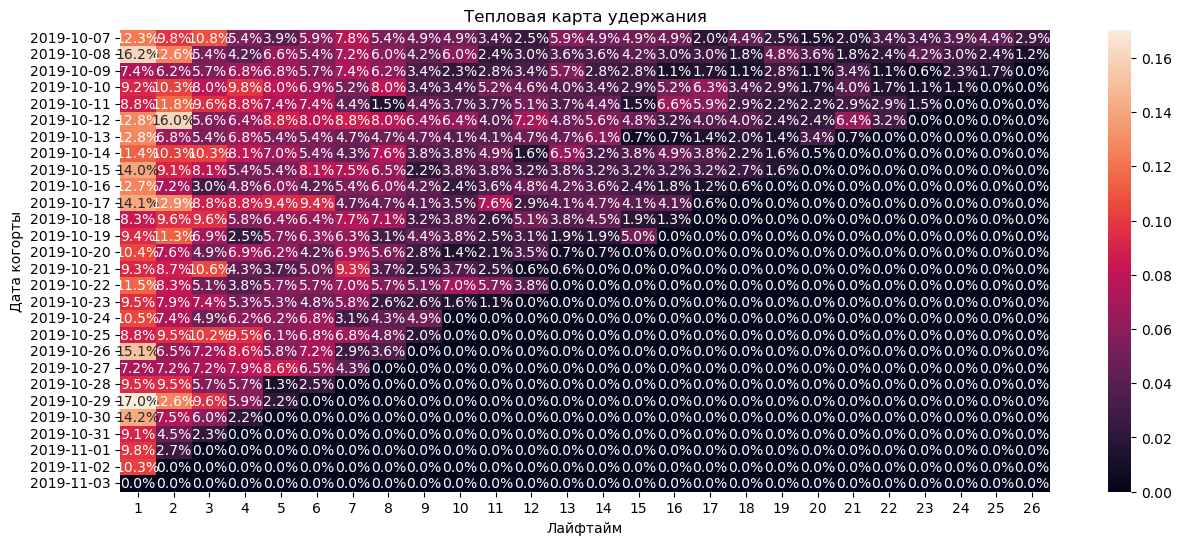

In [72]:
retention_heatmap(retention)

* Самый высокий показатель продления 17% на первый день от 2019-10-29
* Обычно пользователи больше всего возвращаются в течение первой недели

Посмотрим удержание с горизонтами 7 и 14 дней

##### Горизонт 7 дней

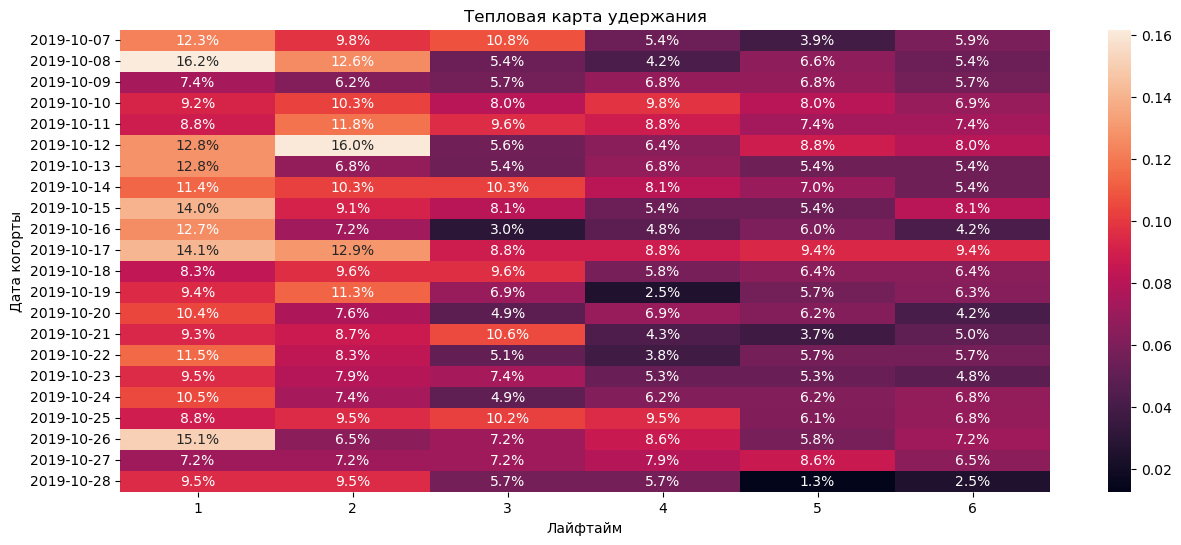

In [73]:
# задаем горизонт в 7 дней, не игнорируем и строим график

retention_raw, retention = get_retention(mobile_df, 
                                         observation_date = max_date, 
                                         horizon_days=7,                 
                                         ignore_horizon=False)

retention_heatmap(retention)

* В целом показатель retention не выше 16.2%
* Больше всего пользователи возвращаются в первые 3-4 дня
* Когорта от 17 октября показывает самый высокий показатель продления на 7ой день = 9.4%
* Когорта от 28 октября - самый низки в 2.5%

##### Горизонт 14 дней

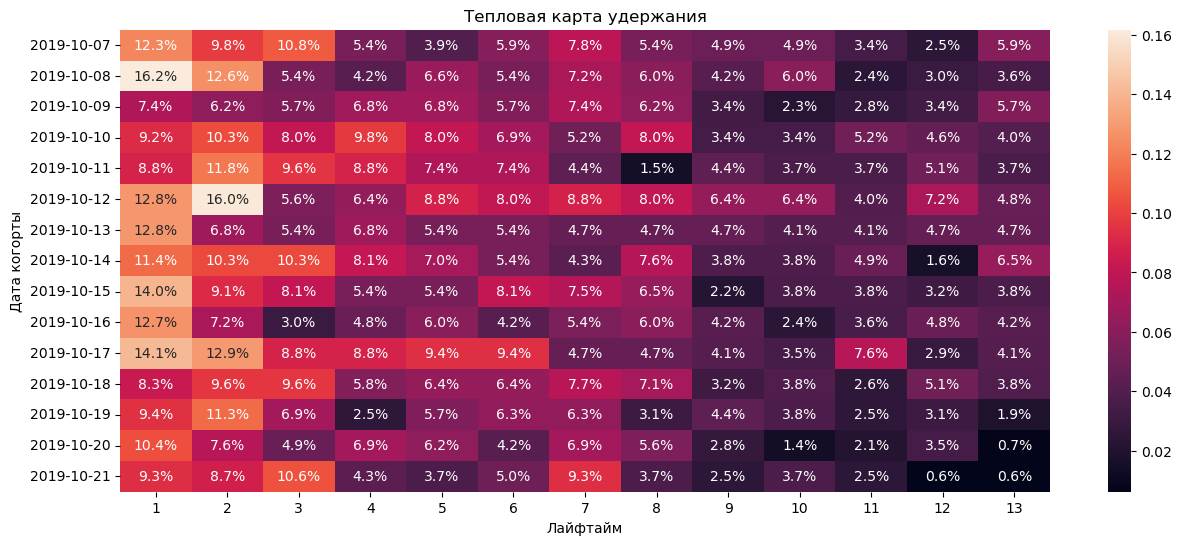

In [74]:
# задаем горизонт в 14 дней, не игнорируем и строим график

retention_raw, retention = get_retention(mobile_df, 
                                         max_date, 
                                         14,                 
                                         ignore_horizon=False)

retention_heatmap(retention)

* На второй неделе удержание продолжает снижение
* Однако пользователи на 14й день могут показывать удержание выше 6%
* В последние 3 дня лайфтайма когорт с 19 до 21 октября - самые низкие показатели удержания от 0.6% до 1.9%, когда в остальные дни удержание от 3.6% до 6.5%

### Время в приложении

Для расчёта времени в приложении понадобится посчитать время каждой сессии.

Поскольку времени окончания сессии у нас нет, то будет считать за время в приложении разницу между первым и последним действием

In [75]:
# посчитаем по уникальным пользователям и сессиям разницу между первым и последним действием в сессии
session_duration = (mobile_df.groupby(['user_id', 'session_id'])['event_time']
                             .agg(['first', 'last'])
                             .diff(axis=1).drop(columns='first')
                   )

# переименуем колонку с продолжительностью
session_duration = session_duration.reset_index().rename(columns={'last': 'duration'})

# переведем продолжительность сессии в минуты
session_duration['duration'] = session_duration['duration'].dt.total_seconds() / 60

session_duration.head()

user_id  session_id   duration
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1   9.928788
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           2   8.456433
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           3  14.987868
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           4  12.636196
4  00157779-810c-4498-9e05-a1e9e3cedf93           1  25.346455

Сгруппируем пользователей по сессиям и посчитаем среднюю продолжительность в минутах

In [76]:
# запишем в новую переменную среднюю продолжительность сессии на пользователя
avg_session = (session_duration.groupby('user_id')
                                 .agg({'duration': 'mean'})['duration']
                ).sort_values().reset_index()

In [77]:
# выведем описание
avg_session.describe()

duration
count  4293.000000
mean     14.258788
std      15.726131
min       0.000000
25%       3.978396
50%       9.376117
75%      19.155104
max     161.014863

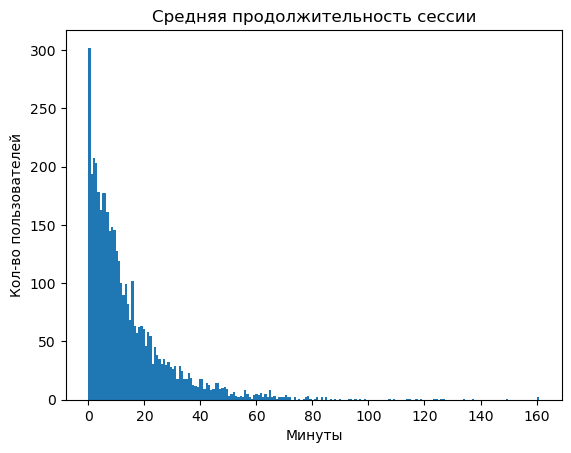

In [78]:
# построим гистограмму
avg_session.plot(kind='hist', bins=200, legend=False);

plt.title('Средняя продолжительность сессии');
plt.xlabel('Минуты');
plt.ylabel('Кол-во пользователей');

Посмотрим количество нулевых сессий

In [79]:
avg_session.query('duration == 0').count()

user_id     83
duration    83
dtype: int64

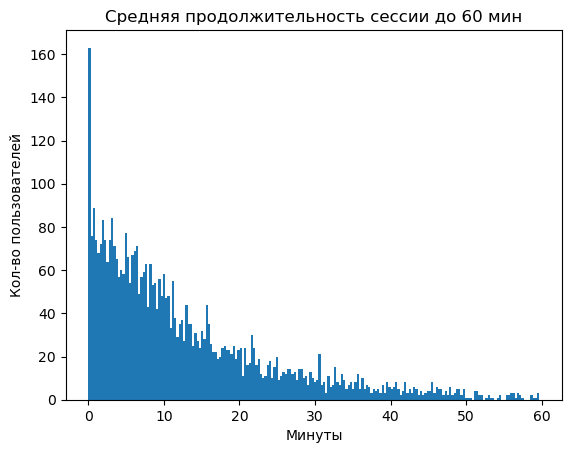

In [80]:
# построим ближе распределение до 60 мин
avg_session.query('duration < 60').plot(kind='hist', bins=200, legend=False);

plt.title('Средняя продолжительность сессии до 60 мин');
plt.xlabel('Минуты');
plt.ylabel('Кол-во пользователей');

**Вывод:**
* Самое большое количество пользователей с нулевой сессией, что скорее всего значит случайное или разовое открытие приложения (сделать короткое действие)
* Среднее время в приложении на одну сессию составляет **14 минут**
* Большинство сессий лежит в диапазоне от 0 до 40 минут
* Есть аномально большие сессии до 160 минут, что может быть вызвано думскролингом пользователя в приложении, работой бота или ошибками

### Частота дейтсвий

Построим частоту действий за весь период исследования

In [81]:
# группируем по действиях, считаем их количество и через plotly строим гистограмму
fig = px.bar(mobile_df.groupby('event_name')['event_time'].agg('count').sort_values(ascending=False))

fig.update_layout(title='Частота действий по типам',
                   xaxis_title='Тип действия',
                   yaxis_title='Частота',
                   showlegend=False,
                   width=800)

fig.show()

* Больше всего показов рекомендованных объявлений `tips_show`. Скорее всего каждый пользователь видит их в приложении первыми
* Далее фото `photos_show` - вероятно, их можно посмотреть без открытия объявления
* Следующим идёт `advert_open` и `contacts_show`
* Пользователи также часто смотрят на карту, однако звонят намного реже

Построим частоту действий по дням

In [82]:
# построим циклом графики по дате, неделе и дню недели

for time in ['date', 'week', 'weekday']:

    fig = px.bar(mobile_df.groupby(time)['event_time'].agg('count'))

    fig.update_layout(title='Частота действий за период: {}'.format(time),
                       xaxis_title=time,
                       yaxis_title='Частота',
                       showlegend=False,
                       width=700)

    fig.show()

* Наименьшее количество действий было на 1 неделе: 15.8 тыс
* Наибольшее количество действий пользователи совершили на 3 неделе: 20.6 тыс, что почти на треть выше 1ой недели
* Пользователи наиболее активны в понедельник и наименее активны в субботу

### Конверсия в целевое действие

Рассчитаем конверсию. Для этого нужно:
* кол-во уникальных пользователей в группе
* кол-во пользователей, которые совершили хотя бы одно целевое действие `contacts_show`
* поделить второе на первое

Напишем функцию для разного ввода временных промежутков и расчёта финальной конверсии

#### `get_conversion`

In [83]:
""" 
df - датасет на вход, dim - разрез

Группируем по dim уникальных пользователей с целевым действием в группе 
и делим на общее кол-во уникальных пользователей группы.

Конверсию умножаем на 100 (в %) и переименовываем в 'cr %'
"""

def get_conversion(df, dim):
    return ((df.query('event_name == "contacts_show"')
              .groupby(dim)
              .agg({'user_id': 'nunique'}) 
            / 
            df.groupby(dim)
              .agg({'user_id': 'nunique'}) * 100)
              .rename(columns={'user_id': 'cr %'})
           )

#### `plot_conversion`

In [84]:
def plot_conversion(conversion, xaxis='Временной интервал'):
    # передаем полученную конверсию из get_conversion   
    fig = px.bar(conversion)

    fig.update_layout(title='Конверсия за период, %',
                       xaxis_title=xaxis,
                       yaxis_title='Конверсия, %',
                       showlegend=False,
                       width=700)

    fig.show()

#### По дням

In [85]:
conversion = get_conversion(mobile_df, 'date')
plot_conversion(conversion, 'День')

#### По неделям и дням недели

Построим понедельную конверсию

In [86]:
conversion = get_conversion(mobile_df, 'week')
plot_conversion(conversion, 'Неделя')

* Конверсия каждую неделю планомерно расчёт с 19.3% на 1ой неделе до 21% на четвертой

In [87]:
conversion = get_conversion(mobile_df, 'weekday')
plot_conversion(conversion, 'День недели (0 = Понедельник)')

* Самая высокая конверсия в целевое действие по пятницам 21.4%
* Самая низкая в понедельник 17.5%

### Вывод

* Анализируемый период **28 дней** (4 полных недели с понедельника по воскресенье)
* Количество сессий за месяц увеличилось с 1900 на 1 неделе до 2900 в среднем на неделе 3-4
* С понедельника по четверг самая высокая активность пользователей: 1535-1583 сессий. В субботу самая низкая: 1279
* По источникам привлечения 45% пришли через Яндекс, 26% через Гугл и 29% из остальных источников
* В зависимости от когорты удержание пользователей на следующий день составляет от 7 до 17%
* Удержание на 7 день снижается в диапазон от 2.5% до 9.4%, на 14 день от 0.6% до 6.5%
* Среднее время в приложении 14 мин, 75% всех сессий в рамках 20 минут. Больше всего околонулевых сессий, что скорее всего вызвано ошибочными открытиями или очень короткими сессиями для разового действия
* Больше всего показов рекомендованных объявлений `tips_show`. Скорее всего каждый пользователь видит их в приложении первыми. Далее фото `photos_show`(вероятно, их можно посмотреть без открытия объявления, потому что потом идёт `advert_open` и уже `contacts_show`)
* Конверсия по дням в течение 28 дней на стабильном уровне в диапазоне от 14.8% до 22.4%, за 4 недели конверсия равномерно росла с 19.3% до 21%. Выше всего конверсия была в пятницу 21.4%, ниже в понедельник 17.5%

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида №2__

Грамотно проведенный этап. Все пункты рассмотрены. Молодец!
</div>

## Анализ поведения в группах

На основе проведенного исследовательского анализа предлагается разделить пользователей по **продолжительности первой сессий**

Это позволит понять, насколько пользователю было понятно приложение, заинтересовало ли оно его и смог ли он в будущем к нему вернуться и что-то купить

По результатам проверим, влияет ли средняя продолжительность сессий пользователей на их конверсию и продление

### Сегментация на группы

In [88]:
# запишем в отдельную переменную продолжительность первых сессий по пользователям
first_session = session_duration.query('session_id == 1').drop(columns='session_id')

# проверим распределение значений
first_session.describe()

duration
count  4293.000000
mean     15.014403
std      18.968061
min       0.000000
25%       2.637111
50%       8.868049
75%      20.610681
max     259.478410

Разделим пользователей на 4 больших группы в зависимости от длинны первой сессии:
* Ультра-короткие: до 2 мин
* Короткие: 2-10 мин
* Средние: 10-30 мин
* Длинные: от 30 мин

In [89]:
# напишем функцию, которой на вход передадим длительность сессии и отрезки, на которые надо поделить
def duration_group(duration, thresholds):
    labels = [f'{i}-{j}' if j != float('inf') else f'{i}+' for i, j in zip([0] + thresholds, thresholds + [float('inf')])]

    for i, threshold in enumerate(thresholds):
        if duration <= threshold:
            return labels[i]
    
    return labels[-1]  # For durations greater than the last threshold

# зададим отрезки в минутах
periods = [2, 10, 30]

first_session['group'] = first_session['duration'].apply(duration_group, thresholds=periods)

In [90]:
first_session.groupby('group')['user_id'].nunique()

group
0-2       936
10-30    1350
2-10     1360
30+       647
Name: user_id, dtype: int64

In [91]:
first_session.head()

user_id   duration  group
0   0001b1d5-b74a-4cbf-aeb0-7df5947bf349   9.928788   2-10
4   00157779-810c-4498-9e05-a1e9e3cedf93  25.346455  10-30
10  00463033-5717-4bf1-91b4-09183923b9df  24.707917  10-30
11  004690c3-5a84-4bb7-a8af-e0c8f8fca64e   3.586077   2-10
17  00551e79-152e-4441-9cf7-565d7eb04090   0.058725    0-2

In [92]:
fig = px.bar(first_session.groupby('group').agg({'duration': 'count'}))

fig.update_layout(title='Количество пользователей по длине первой сессии',
                   xaxis_title='Длина сессии, мин',
                   yaxis_title='Кол-во пользователей',
                   showlegend=False,
                   width=500, height=400) 

* Получились 4 больших группы

Добавим индикатор группы в таблицу `mobile_df`

In [93]:
mobile_df = mobile_df.merge(first_session[['user_id', 'group']], on='user_id')

In [94]:
mobile_df.head()

user_id source event_name  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
4  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   

                  event_time  session_id        date  weekday    week  \
0 2019-10-07 13:39:45.989359           1  2019-10-07        0  week 1   
1 2019-10-07 13:40:31.052909           1  2019-10-07        0  week 1   
2 2019-10-07 13:41:05.722489           1  2019-10-07        0  week 1   
3 2019-10-07 13:43:20.735461           1  2019-10-07        0  week 1   
4 2019-10-07 13:45:30.917502           1  2019-10-07        0  week 1   

                    first_ts  lifetime  first_date group  
0 2019-10-07 13:39:45.989359         0  2019-10-07  2-10  
1 2019-10-07 13:39:45.989359         0  2019-10-07  2-10  
2 2019-10-07 13:39:45.989359         0  2019-10-07  2-10  
3 2019-10-07 13:39:45.989359         0  2019-10-07  2-10  
4 2019-10-07 13:39:45.989359         0  2019-10-07  2-10

### `Retention rate` в группах

Построит тепловую карту по группам первой сессии в приложении, а также выведем таблицу удержания, чтобы понимать, кол-во пользователей каждой когорты

#### Общее удержание по группам

**7 дней**

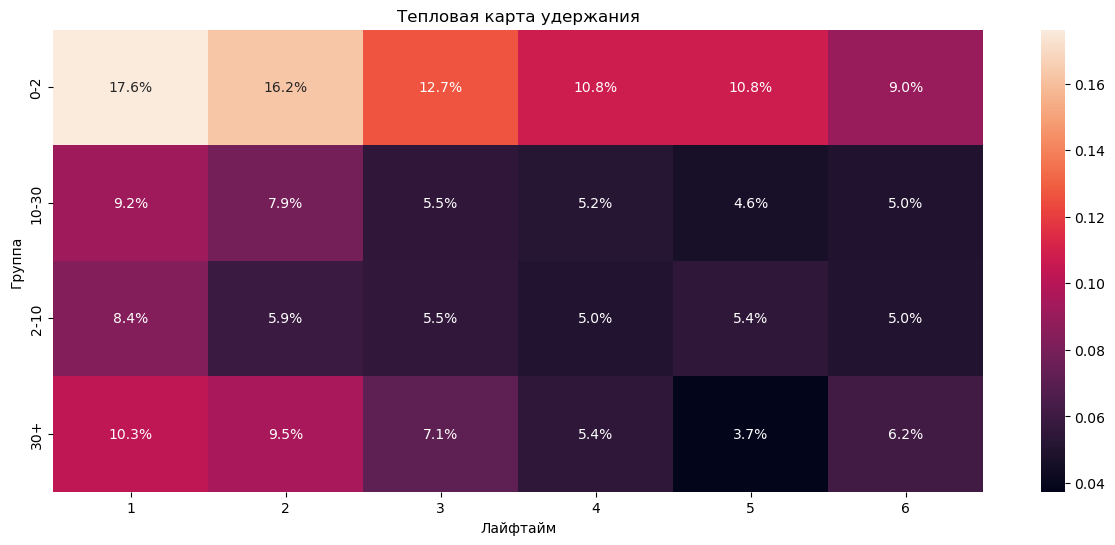

In [95]:
retention_raw, retention = get_retention(mobile_df, 
                                             max_date,               # задаем последнюю дату исследования
                                             7,                      # интервал в днях                  
                                             ignore_horizon=False,
                                             dimensions=['group'])   

# выводит тепловую карту
retention_heatmap(retention, ylabel='Группа')

# # строим график продления на 7ой день
# fig = px.bar(retention[6].T, text_auto='.2%')

# fig.update_layout(title='График удержания по группам',
#                    xaxis_title='Дата когорты',
#                    yaxis_title='Retention rate',
#                    showlegend=False)

* У самый короткий сессий самый большой процент продления на 7 день = 9.0%
* Второе место у самый длинный (30+ мин) = 6.2
* В группаъ от 2-10 и 10-30 минут продление = 5.0%

**14 дней**

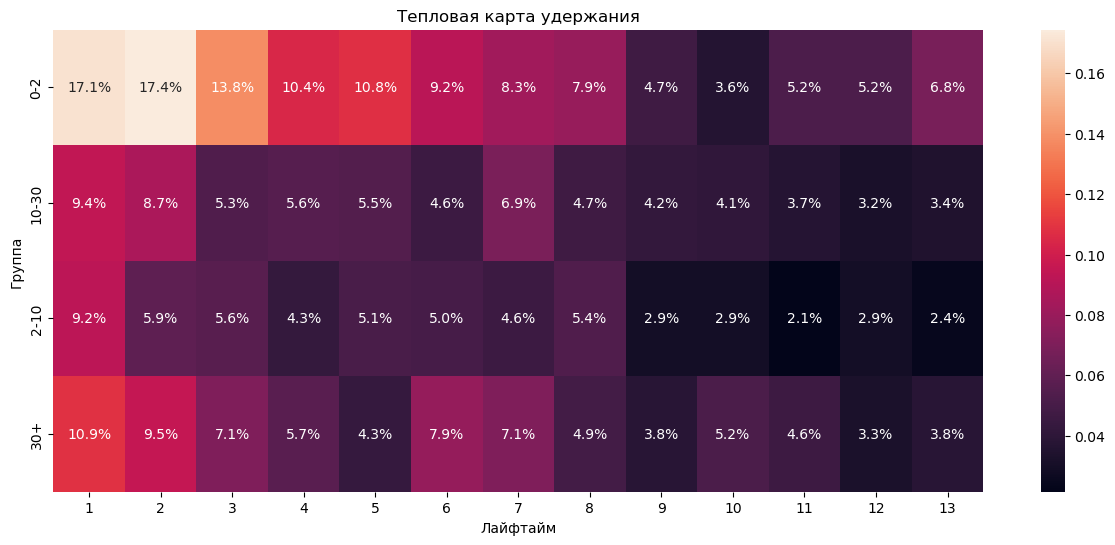

In [96]:
retention_raw, retention = get_retention(mobile_df, 
                                             max_date,               # задаем последнюю дату исследования
                                             14,                     # интервал в днях                  
                                             ignore_horizon=False,
                                             dimensions=['group'])   # делим лайфтаймы по группам

# выводит тепловую карту
retention_heatmap(retention, ylabel='Группа')

* На 14 день лидерами также остаются самые короткие и длинные сессии 0-2 и 30+: 6.8% и 3.8% соответственно
* Но продление у группы 10-30 снижается заметно ниже, чем у группы 2-10: 3.4% против 2.4%

#### Удержание 7 дней

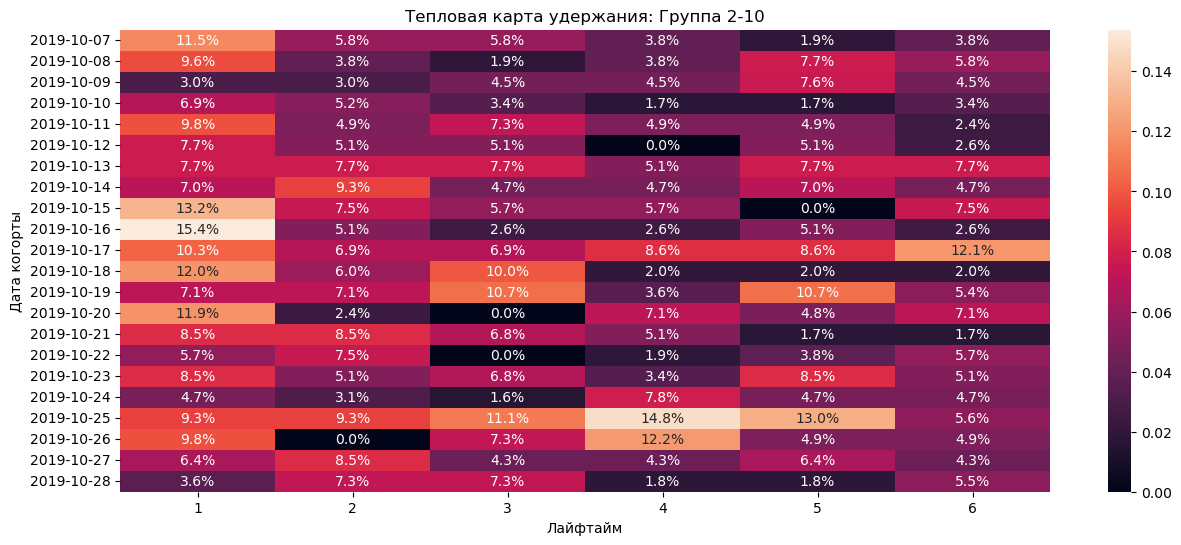

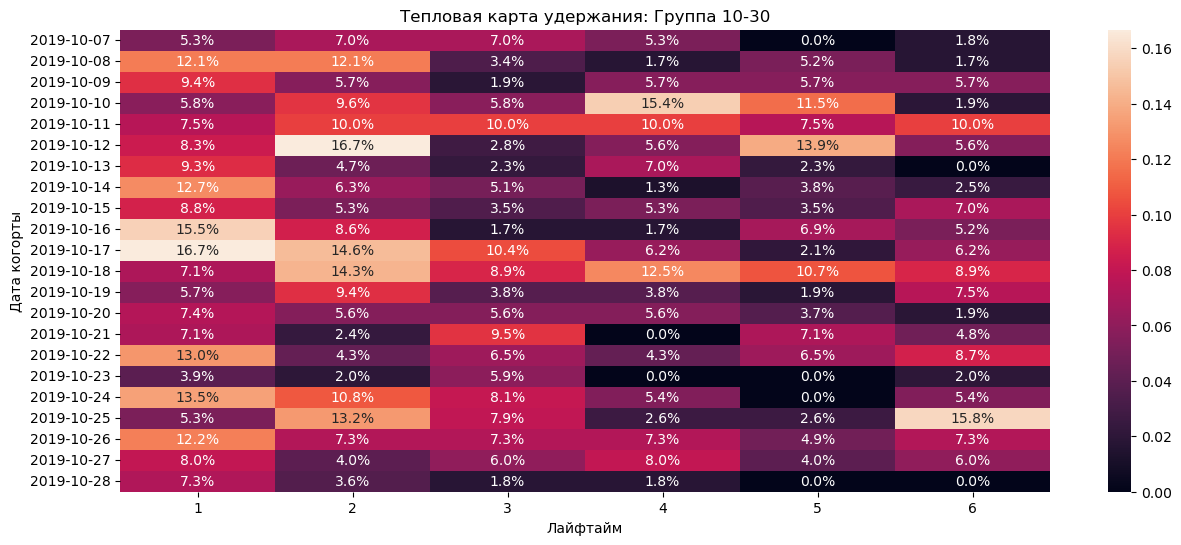

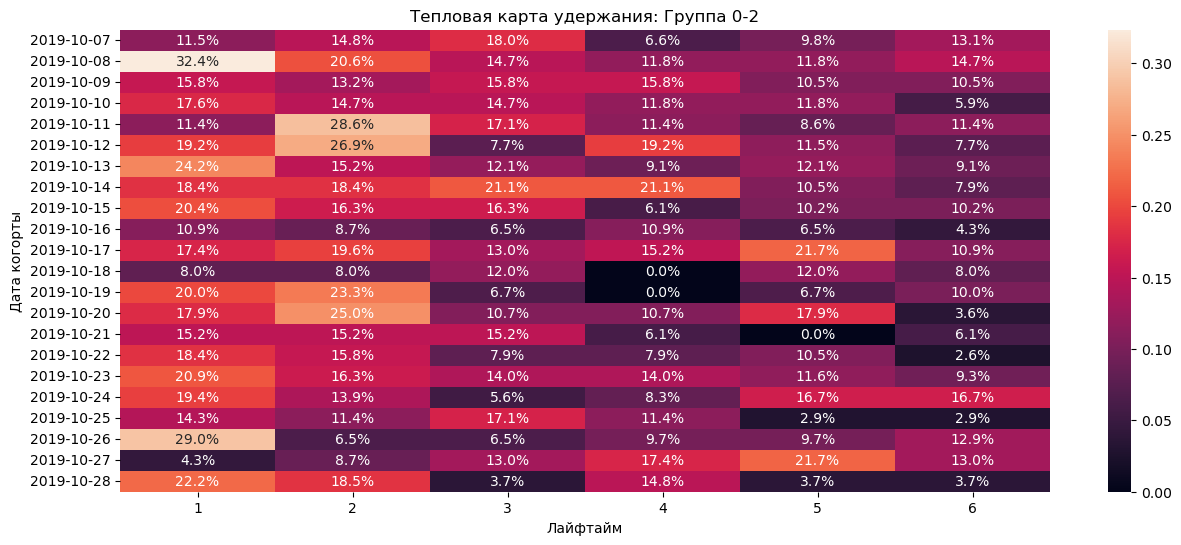

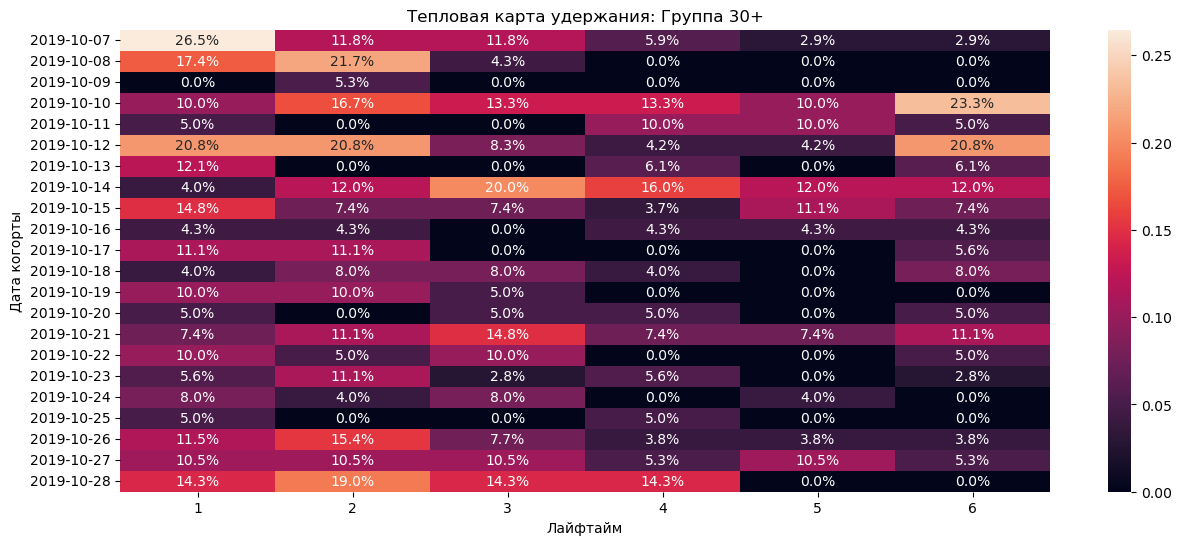

In [97]:
for group in mobile_df['group'].unique():
    
    # считаем продление
    retention_raw, retention = get_retention(mobile_df.query('group == @group'), 
                                             max_date,               # задаем последнюю дату исследования
                                             7,                      # интервал в днях                  
                                             ignore_horizon=False)   
    
    # выводит тепловую карту
    retention_heatmap(retention, title=('Тепловая карта удержания: Группа {}'.format(group)))

#### Удержание 14 дней

Группа: 2-10


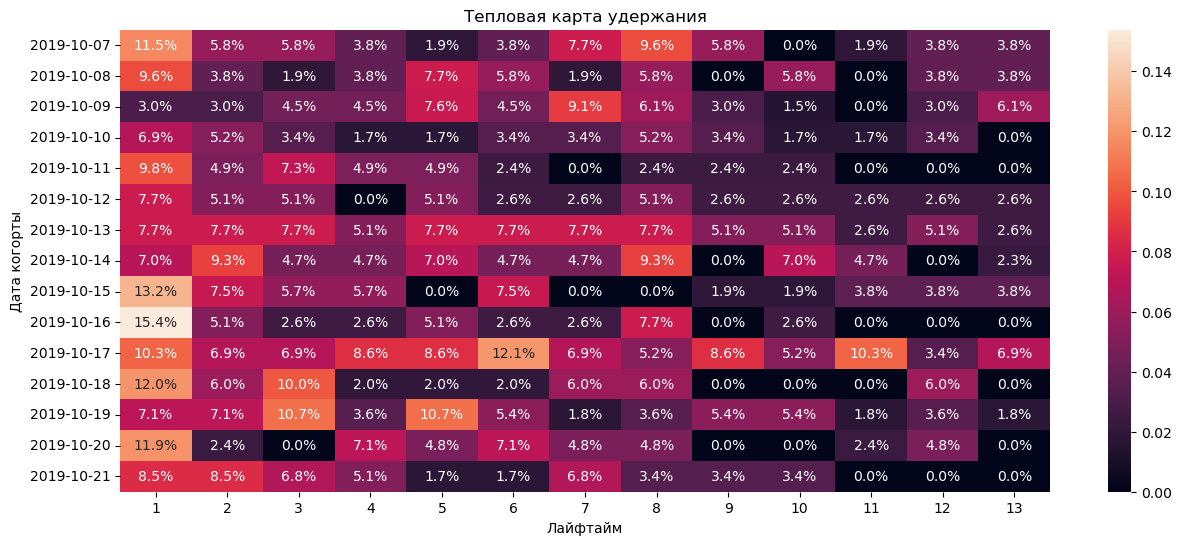

Группа: 10-30


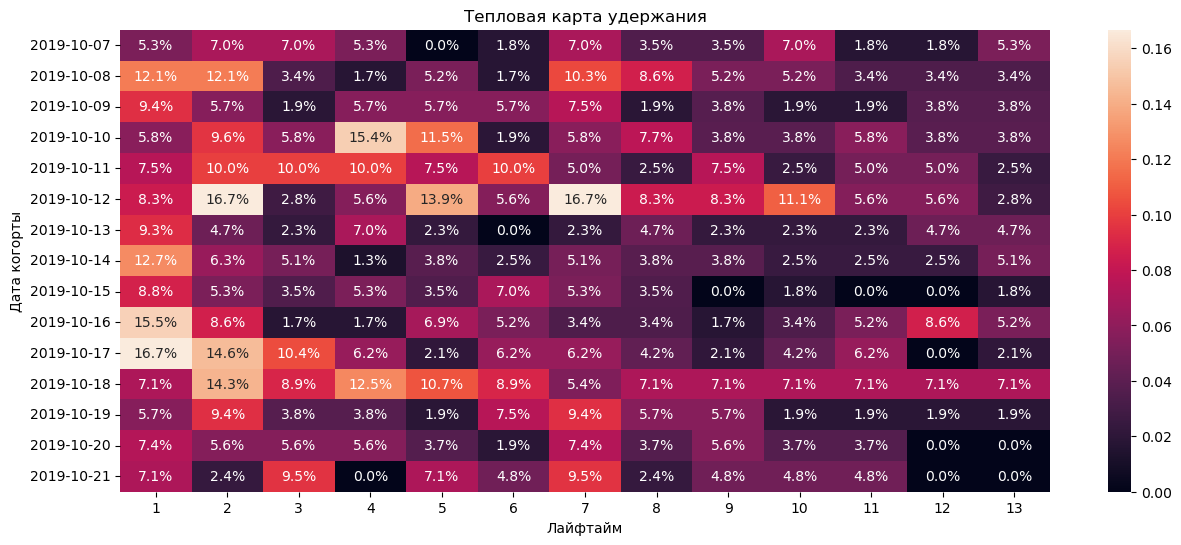

Группа: 0-2


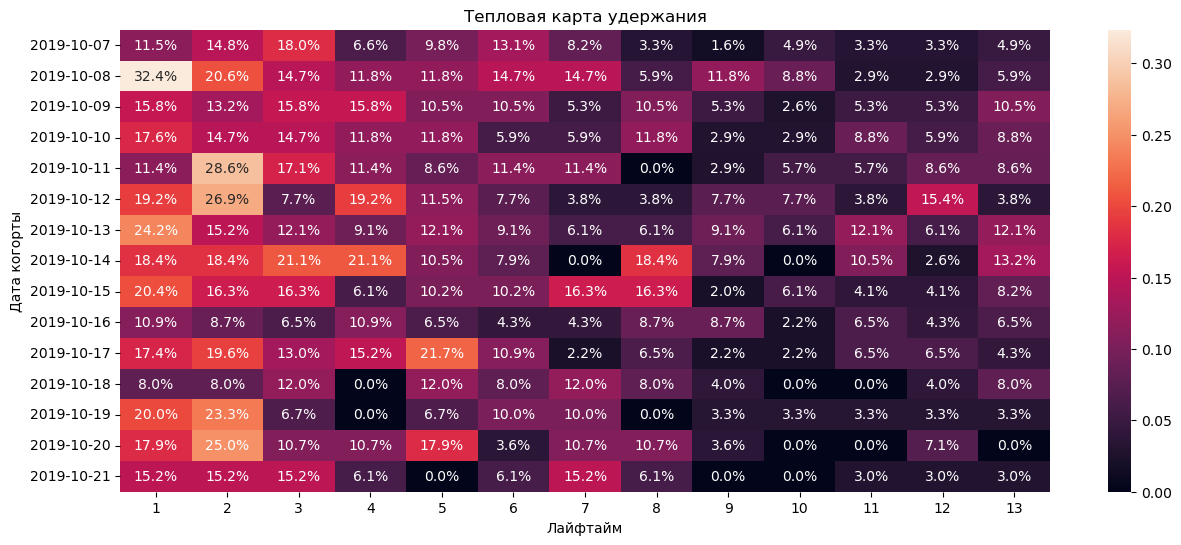

Группа: 30+


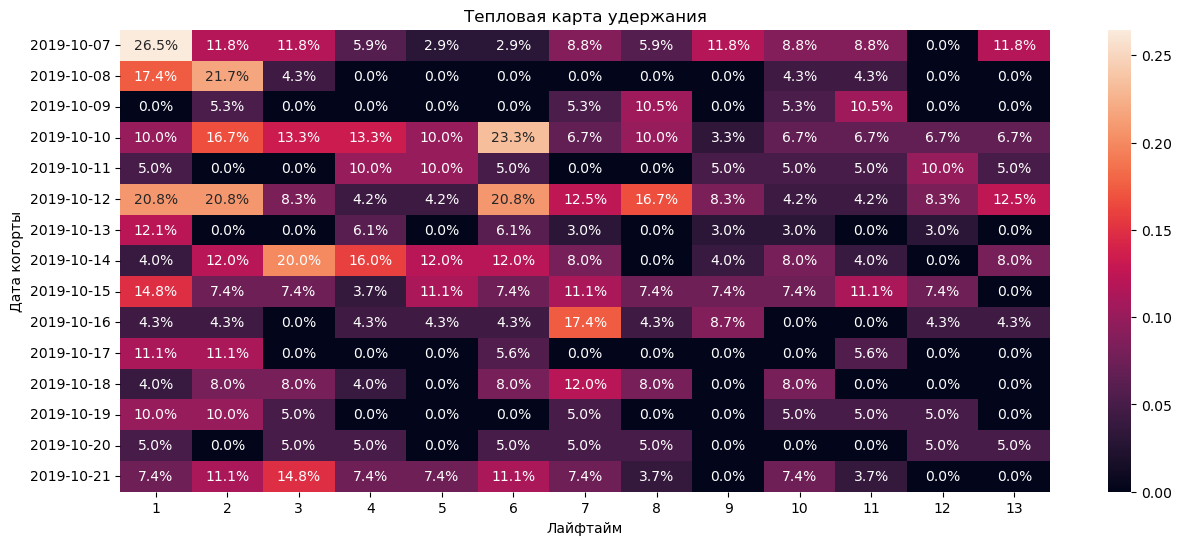

In [98]:
for group in mobile_df['group'].unique():
    
    retention_raw, retention = get_retention(mobile_df.query('group == @group'), 
                                             max_date, # задаем последнюю дату исследования
                                             14,                      # 2 недели                   
                                             ignore_horizon=False)   
    print('Группа:', group)
    
    retention_heatmap(retention)

* У группы 30+ самое большое количество дней с нулевым продлением. Что может быть логично, потому что пользователь мог найти нужный товар и больше не возвращаться
* Группа 0-2 демонстрирует крайне высокий процент возвращения на протяжении первых семи дней
* По группе 10-30 самое равномерное распределение возвратов в приложение

### `Конверсия` в группах

Построим понедельные графики конверсии пользователей в каждой группе и выведем общее количество уникальных пользователей в группе за каждую неделю

#### Общая конверсия по группам

In [99]:
conversion = get_conversion(mobile_df, 'group')
plot_conversion(conversion, 'Группа')

#### Понедельная конверсия в группах

In [100]:
for group in mobile_df['group'].unique():
    
    print('Группа:', group)
    conversion = get_conversion(mobile_df.query('group == @group'), 'week')
    plot_conversion(conversion, 'Неделя')
    
    # выведем общее количество пользователей 
    print('Уникальные пользователи по неделям:')
    display(mobile_df.query('group == @group').groupby('week').agg({'user_id': 'nunique'}).T)
    
    print('')

Группа: 2-10


Уникальные пользователи по неделям:


week     week 1  week 2  week 3  week 4
user_id     347     404     484     440


Группа: 10-30


Уникальные пользователи по неделям:


week     week 1  week 2  week 3  week 4
user_id     339     473     420     432


Группа: 0-2


Уникальные пользователи по неделям:


week     week 1  week 2  week 3  week 4
user_id     261     350     408     349


Группа: 30+


Уникальные пользователи по неделям:


week     week 1  week 2  week 3  week 4
user_id     183     211     234     195

### Вывод

**Продление:**
* У самых коротких сессий самый большой процент продления на 7 день = 9.0%, 2ое место у самой длинной 30+ = 6.2%
* В группам от 2-10 и 10-30 минут продление на 7 день = 5.0%
* На 14 день картина между 2-10 и 10-30 меняется и выше становится процент у 10-30 = 3.4% против 2.4% у 2-10
* В целом по группам продление снижается не линейно, а волнообразно. Предположительно, пользователи вновь возвращаются в приложение за новыми объявлениями о покупке и продаже


**Конверсия:**
* Однако наилучшую конверсию показывают пользователи, которые проводят в приложении более 30 мин = 27.5%, далее идет 0-2 с конверсией в 25.6%. Конверсии у группы 2-10: 19.9%, у 10-30: 21.6%
* Предположительно, высокая конверсия у крайних групп может объясняется тем, что пользователь, который либо очень быстро нашёл объявление либо долго и вдумчиво искал - лучше всего конвертируется в целевое действие
* С точки зрения динамики по неделям в группах ситуация разная, несмотря на общий тренд роста. Следует исследовать причины роста конверсии в группах 2-10 и 0-2 на дополнительных данных

## Проверка гипотез

### Yandex vs Google

**Гипотеза 1:** Конверсия пользователей, которые установили приложение по ссылке из `yandex` и из `google` разные

* H_0: Конверсия пользователей из `yandex` = Конверсия пользователей из `google`
* H_a: Конверсия пользователей из `yandex` ≠ Конверсия пользователей из `google`
* alpha = 0.05

Поскольку сравниваем доли конверсий, то используем `ztest`

Зададим формулу для проведения z-теста

In [101]:
"""
`successes` - [количество уникальных пользователей которые совершили `действие` в группе A, 
количество уникальных пользователей которые совершили `действие` в группе B]

`trials`- [общее количество уникальных пользователей в группе A, 
общее количество уникальных пользователей в группе B]
"""

def z_test(successes1, successes2, trials1, trials2, alpha=0.05):
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    
    print(successes1, successes2, trials1, trials2)

    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)

    if (p_value < alpha):
        display('Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия')
    else:
        display('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет')

Расчитаем переменные `successes1`, `successes2`, `trials1`, `trials2` для z-теста

In [102]:
def successes_trials(df, dim):
    test_sessions = (df.query('event_name == "contacts_show"').groupby(dim).agg({'user_id': 'nunique'})
                     .merge(df.groupby(dim)
                              .agg({'user_id': 'nunique'}), on=dim, how='left')
                              .rename(columns={'user_id_x': 'successes',
                                               'user_id_y': 'trials'})
                    )
    return test_sessions

In [103]:
test_sessions = successes_trials(mobile_df, 'source')
test_sessions

successes  trials
source                   
google        275    1129
other         228    1230
yandex        478    1934

Проверяем гипотезы

In [104]:
z_test(test_sessions.loc['google', 'successes'], 
       test_sessions.loc['yandex', 'successes'], 
       test_sessions.loc['google', 'trials'], 
       test_sessions.loc['yandex', 'trials'])

275 478 1129 1934
p-значение:  0.8244316027993777


'Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет'

* Статистически не удалось отвергнуть гипотезу о равенстве конверсии пользователей, пришедших через Яндекс и Гугл 

### Влияние просмотра фотографий

**Гипотеза 2:** Конверсия пользователей, которые смотрели и не смотрели фотографии в сессии  - разные

* H_0: Конверсия пользователей с просмотром фотографий = Конверсия пользователей без просмотра фотографий
* H_a: Конверсия пользователей с просмотром фотографий ≠ Конверсия пользователей без просмотра фотографий
* alpha = 0.05


Предварительно выделим пользователей, которые смотрели фотографии и нет

In [105]:
# отметим сессии пользователей маркером True, у которых был показ фото
yes_show = (
mobile_df.query('event_name == "photos_show"')
          .groupby(['user_id', 'session_id'])
          .count()
          .reset_index()[['user_id', 'session_id']]
)

yes_show['photos_show'] = True
yes_show

user_id  session_id  photos_show
0     00157779-810c-4498-9e05-a1e9e3cedf93           1         True
1     00157779-810c-4498-9e05-a1e9e3cedf93           2         True
2     00157779-810c-4498-9e05-a1e9e3cedf93           3         True
3     00157779-810c-4498-9e05-a1e9e3cedf93           4         True
4     00157779-810c-4498-9e05-a1e9e3cedf93           5         True
...                                    ...         ...          ...
2521  ff1554b5-919e-40b1-90bb-ee1f7f6d5846           1         True
2522  ffc01466-fdb1-4460-ae94-e800f52eb136           1         True
2523  ffe68f10-e48e-470e-be9b-eeb93128ff1a           1         True
2524  ffe68f10-e48e-470e-be9b-eeb93128ff1a           2         True
2525  ffe68f10-e48e-470e-be9b-eeb93128ff1a           3         True

[2526 rows x 3 columns]

In [106]:
# добавим колонку с маркером True по пользователю и номеру сессии (где не подтянется, то False)
mobile_df = mobile_df.merge(yes_show, on=['user_id', 'session_id'], how='left').fillna(False)

In [107]:
mobile_df.head()

user_id source event_name  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   
4  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  other  tips_show   

                  event_time  session_id        date  weekday    week  \
0 2019-10-07 13:39:45.989359           1  2019-10-07        0  week 1   
1 2019-10-07 13:40:31.052909           1  2019-10-07        0  week 1   
2 2019-10-07 13:41:05.722489           1  2019-10-07        0  week 1   
3 2019-10-07 13:43:20.735461           1  2019-10-07        0  week 1   
4 2019-10-07 13:45:30.917502           1  2019-10-07        0  week 1   

                    first_ts  lifetime  first_date group  photos_show  
0 2019-10-07 13:39:45.989359         0  2019-10-07  2-10        False  
1 2019-10-07 13:39:45.989359         0  2019-10-07  2-10        False  
2 2019-10-07 13:39:45.989359         0  2019-10-07  2-10        False  
3 2019-10-07 13:39:45.989359         0  2019-10-07  2-10        False  
4 2019-10-07 13:39:45.989359         0  2019-10-07  2-10        False

Индикатор появился. Теперь проверим, есть ли уникальные пользователи, которые смотрели и не смотрели фотографии

In [108]:
photos_users = (
pd.pivot_table(mobile_df, 
               index='user_id', 
               columns='photos_show', 
               aggfunc={'photos_show': 'sum'}).reset_index(col_level=1)
    )

photos_users.columns = ['user_id', 'noshow', 'show']
photos_users.query('noshow.notnull() & show.notnull()')

user_id  noshow  show
1     00157779-810c-4498-9e05-a1e9e3cedf93     0.0  70.0
4     00551e79-152e-4441-9cf7-565d7eb04090     0.0   1.0
10    00753c79-ea81-4456-acd0-a47a23ca2fb9     0.0  17.0
34    01d283e1-cb1c-407a-a4e0-9f72f3deecca     0.0   9.0
47    030fbe1b-7e5b-49a4-af82-570189847f10     0.0   2.0
...                                    ...     ...   ...
4241  fc70e232-134b-4880-9313-bf1c0919e91d     0.0  17.0
4246  fcd6ca44-af2d-4d54-9cc8-0e625f3fa9ae     0.0   2.0
4251  fd0bc38a-3c2d-4d12-9de2-b6b52c17177c     0.0   3.0
4262  fd9b3591-9dd3-48c4-804d-cbcbb9a3b8da     0.0   4.0
4284  ff1554b5-919e-40b1-90bb-ee1f7f6d5846     0.0   2.0

[341 rows x 3 columns]

Получился 341 пользователь. Выделим их в отдельную переменную

In [109]:
duplicated_users = list(photos_users.query('noshow.notnull() & show.notnull()')['user_id'])

duplicated_users

['00157779-810c-4498-9e05-a1e9e3cedf93',
 '00551e79-152e-4441-9cf7-565d7eb04090',
 '00753c79-ea81-4456-acd0-a47a23ca2fb9',
 '01d283e1-cb1c-407a-a4e0-9f72f3deecca',
 '030fbe1b-7e5b-49a4-af82-570189847f10',
 '037c3a07-9382-41ef-881a-90b6a55eaa9b',
 '03bef3ef-cce8-46ed-8c70-414b6b0486fb',
 '042ebe74-a35b-41d5-abf8-ef6786918951',
 '06322fa8-a60f-486f-862c-df21ce5bbb83',
 '06d168a5-79d3-45ad-906e-872ef5de936f',
 '07efcf91-4d1a-45c4-aba3-6590bb22ec52',
 '07eff6a2-4b3c-4f16-8fa0-87b5731d3ab2',
 '082fdad3-ec9a-48f6-89c8-ecd28bbc09e0',
 '08ff0fce-e12b-4f7e-8680-34e105f7f537',
 '09313359-30a5-40c4-bf1f-f16acd21e99a',
 '0a21a0ed-4478-4dd3-beb5-eac850063186',
 '0a9efcb4-c2c5-4440-ac37-5bf5323bed02',
 '0ae3d388-826c-480d-a3db-066591bc94a7',
 '0afc1e37-b1a7-49ff-b945-be564743dc99',
 '0c01df72-689e-4a2c-bb76-518a8d1d22b1',
 '0d85d9de-7d8c-4fe0-8729-b558d1bd1669',
 '0f676893-b238-4a16-b135-6c98708c51d7',
 '0fcdbd5f-8eee-403c-9290-7e6ccbddb5aa',
 '0fd90f01-285d-4ac7-9ae4-cbaa96dae042',
 '10d0cef5-b61b-

Проверим, сколько от большего кол-ва пользователей мы будем исключать

In [110]:
len(duplicated_users) / mobile_df['user_id'].nunique()

0.07943163289075239

Почти 8%. Многовато, но допустимо для дальнейшего анализа

Рассчитаем теперь `successes` / `trials` и проверим гипотезу (исключив дубликаты пользователей)

In [111]:
test_sessions = successes_trials(mobile_df[~mobile_df['user_id'].isin(duplicated_users)], 'photos_show')
test_sessions

successes  trials
photos_show                   
False              642    3198
True               152     754

In [112]:
z_test(test_sessions.loc[False, 'successes'], 
       test_sessions.loc[True, 'successes'], 
       test_sessions.loc[False, 'trials'], 
       test_sessions.loc[True, 'trials'])

642 152 3198 754
p-значение:  0.9586495047013344


'Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет'

In [113]:
# выведем конверсию по группам
get_conversion(mobile_df[~mobile_df['user_id'].isin(duplicated_users)], 'photos_show')

cr %
photos_show           
False        20.075047
True         20.159151

* Нулевую гипотезу о равенстве конверсий отвергли отвергнуть не удалось, поэтому статистически значиой разницы нет между пользователями, смотревшими и не смотревшими фотографии

### Вывод

**Гипотеза 1**: "Конверсии пользователей из Яндекса и Гугла разные"
* Не удалось отвергнуть нулевую гипотезу о равенстве конверсии пользователей, пришедших через Яндекс и Гугл
* Можно предположить, что **конверсия этих пользователей значимо не отличается**

**Гипотеза 2**: "Конверсии пользователей, которые посмотрели фотографии и нет - разные"
* Нулевую гипотезу о равенстве конверсий отвергли отвергнуть не удалось
* **Статистически значиой разницы нет** между пользователями, смотревшими и не смотревшими фотографии

## Общий вывод

### Данные и предобработка

* На вход получили два файла без ошибок, пропусков и дубликатов (+ команде) сбора данных
* В файле действиями пользователей сделали разбивку по сессиям по 30-мин интервалу между действиями
* Объединили два сета данных (сессии и источники) в один и упорядочили колонки
* Потенциально можно дополнить:
    * описанием метрик `search_1-7`, 
    * получить продажи, 
    * проработать логику поведения пользователя в приложении 
        * Какая последовательность действий пользователя
        * Что пользователь видит на каждом этапе (например, фотографии)

### Исследовательский анализ

* Анализируемый период **28 дней** (4 полных недели с понедельника по воскресенье)
* Количество сессий за месяц увеличилось с 1900 на 1 неделе до 2900 в среднем на неделе 3-4
* С понедельника по четверг самая высокая активность пользователей: 1535-1583 сессий. В субботу самая низкая: 1279
* По источникам привлечения 45% пришли через Яндекс, 26% через Гугл и 29% из остальных источников
* В зависимости от когорты удержание пользователей на следующий день составляет от 7 до 17%
* Удержание на 7 день снижается в диапазон от 2.5% до 9.4%, на 14 день от 0.6% до 6.5%
* Среднее время в приложении 14 мин, 75% всех сессий в рамках 20 минут. Больше всего околонулевых сессий, что скорее всего вызвано ошибочными открытиями или очень короткими сессиями для разового действия
* Больше всего показов рекомендованных объявлений `tips_show`. Скорее всего каждый пользователь видит их в приложении первыми. Далее фото `photos_show`(вероятно, их можно посмотреть без открытия объявления, потому что потом идёт `advert_open` и уже `contacts_show`)
* Конверсия по дням в течение 28 дней на стабильном уровне в диапазоне от 14.8% до 22.4%, за 4 недели конверсия равномерно росла с 19.3% до 21%. Выше всего конверсия была в пятницу 21.4%, ниже в понедельник 17.5%

### Анализ в группах

**Методика анализа:**
* Группы были разделены по продолжительности первой сессии, т.е. как первый опыт в приложении повлиял на дальнейшее поведения пользователя
* Группы были разделены на 4 длительности сессий:
    * Ультра-короткие: до 2 мин
    * Короткие: 2-10 мин
    * Средние: 10-30 мин
    * Длинные: от 30 мин
* По группам анализировались *Продление* и *Конверсия*


**Продление:**
* У самых коротких сессий самый большой процент продления на 7 день = 9.0%, 2ое место у самой длинной 30+ = 6.2%
* В группам от 2-10 и 10-30 минут продление на 7 день = 5.0%
* На 14 день картина между 2-10 и 10-30 меняется и выше становится процент у 10-30 = 3.4% против 2.4% у 2-10
* В целом по группам продление снижается не линейно, а волнообразно. Предположительно, пользователи вновь возвращаются в приложение за новыми объявлениями о покупке и продаже


**Конверсия:**
* Однако наилучшую конверсию показывают пользователи, которые проводят в приложении более 30 мин = 27.5%, далее идет 0-2 с конверсией в 25.6%. Конверсии у группы 2-10: 19.9%, у 10-30: 21.6%
* Предположительно, высокая конверсия у крайних групп может объясняется тем, что пользователь, который либо очень быстро нашёл объявление либо долго и вдумчиво искал - лучше всего конвертируется в целевое действие
* С точки зрения динамики по неделям в группах ситуация разная, несмотря на общий тренд роста. Следует исследовать причины роста конверсии в группах 2-10 и 0-2 на дополнительных данных

### Проверка гипотез

В рамках исследования были проверены две гипотезы:

**Гипотеза 1**: "Конверсии пользователей из Яндекса и Гугла разные"
* Не удалось отвергнуть нулевую гипотезу о равенстве конверсии пользователей, пришедших через Яндекс и Гугл
* Можно предположить, что **конверсия этих пользователей значимо не отличается**

**Гипотеза 2**: "Конверсии пользователей, которые посмотрели фотографии и нет - разные"
* Нулевую гипотезу о равенстве конверсий отвергли отвергнуть не удалось
* **Статистически значиой разницы нет между пользователями, смотревшими фотографии и нет**